3.Data Cleaning and Preparation
-
Load and Inspect Data
-

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("D:/STUDY/SYMBIOSIS/SEM 7/Project/Energy_deficit.csv")

# Show first few rows
df.head()

,Region,State,is_union_territory,Month,Quarter,Energy Requirement MU,Energy Availability MU,Energy_Deficit
0,North,Chandigarh,1,Mar,Q1,101.600,101.600,0.000
1,North,Delhi,1,Mar,Q1,2130.478,2130.279,0.199
2,North,Haryana,0,Mar,Q1,3911.822,3909.160,2.662
3,North,Himachal Pradesh,0,Mar,Q1,1025.630,1023.160,2.470
4,North,UTs of J&K and Ladakh,1,Mar,Q1,1725.610,1717.930,7.680


Check Shape, Data Types, and Null Values
-

In [2]:
# Dataset shape
print("Dataset shape:", df.shape)

# Data types and nulls
print("\nData types and missing values:")
print(df.info())

# Summary of null values
print("\nMissing values in each column:")
print(df.isnull().sum())

Dataset shape: (350, 8)

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Region                  350 non-null    object 
 1   State                   350 non-null    object 
 2   is_union_territory      350 non-null    int64  
 3   Month                   350 non-null    object 
 4   Quarter                 350 non-null    object 
 5   Energy Requirement MU   350 non-null    float64
 6   Energy Availability MU  350 non-null    float64
 7   Energy_Deficit          350 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 22.0+ KB
None

Missing values in each column:
Region                    0
State                     0
is_union_territory        0
Month                     0
Quarter                   0
Energy Requirement MU     0
Energy Availability MU    0
Energy_Deficit

Normalize column names (strip/ lower / replace non-alnum with underscore)
-

In [3]:
df.columns = (df.columns
                .astype(str)
                .str.strip()
                .str.lower()
                .str.replace(r'[^0-9a-z]+', '_', regex=True)
                .str.strip('_')
             )

print("\nColumns after normalization:", list(df.columns))


Columns after normalization: ['region', 'state', 'is_union_territory', 'month', 'quarter', 'energy_requirement_mu', 'energy_availability_mu', 'energy_deficit']


Trim whitespace and standardize text columns
-

In [4]:
text_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in text_cols:
    df[c] = df[c].astype(str).str.strip()  # keep as str for parsing step

# Title-case region/state (but keep 'month' / 'quarter' as-is)
if 'region' in df.columns:
    df['region'] = df['region'].str.title()
if 'state' in df.columns:
    df['state'] = df['state'].str.title()


Ensure numeric columns are numeric (coerce errors -> NaN)
-

In [5]:
numeric_cols = []
for col in ['energy_requirement_mu', 'energy_availability_mu', 'energy_deficit']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        numeric_cols.append(col)

print("\nNumeric columns checked:", numeric_cols)


Numeric columns checked: ['energy_requirement_mu', 'energy_availability_mu', 'energy_deficit']


Convert is_union_territory to boolean if present
-

In [6]:
if 'is_union_territory' in df.columns:
    try:
        df['is_union_territory'] = pd.to_numeric(df['is_union_territory'], errors='coerce').fillna(0).astype(int).astype(bool)
    except Exception:
        df['is_union_territory'] = df['is_union_territory'].apply(lambda x: str(x).strip().lower() in ('1','true','yes','y'))


Report missing values & duplicates introduced by coercion
-

In [7]:
print("\nMissing values per column (after coercion):")
print(df.isna().sum())

dupes = df.duplicated().sum()
print(f"\nDuplicate rows detected: {dupes}")
if dupes > 0:
    print("Sample duplicate rows (first 5):")
    display(df[df.duplicated(keep=False)].head())


Missing values per column (after coercion):
region                    0
state                     0
is_union_territory        0
month                     0
quarter                   0
energy_requirement_mu     0
energy_availability_mu    0
energy_deficit            0
dtype: int64

Duplicate rows detected: 0


Simple outlier detection (IQR) for numeric columns
-

In [8]:
outlier_report = {}
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_count = mask.sum()
    outlier_report[col] = {'count': int(outlier_count), 'lower': float(lower), 'upper': float(upper)}
print("\nOutlier report (IQR method):")
for k,v in outlier_report.items():
    print(f" - {k}: {v['count']} outliers (outside [{v['lower']:.3f}, {v['upper']:.3f}])")



Outlier report (IQR method):
 - energy_requirement_mu: 7 outliers (outside [-9580.443, 16447.334])
 - energy_availability_mu: 7 outliers (outside [-9614.250, 16459.750])
 - energy_deficit: 58 outliers (outside [-9.977, 16.628])


Final checks & save cleaned file
-

In [9]:
print("\nFinal shape:", df.shape)
display(df.head())


Final shape: (350, 8)


,region,state,is_union_territory,month,quarter,energy_requirement_mu,energy_availability_mu,energy_deficit
0,North,Chandigarh,True,Mar,Q1,101.600,101.600,0.000
1,North,Delhi,True,Mar,Q1,2130.478,2130.279,0.199
2,North,Haryana,False,Mar,Q1,3911.822,3909.160,2.662
3,North,Himachal Pradesh,False,Mar,Q1,1025.630,1023.160,2.470
4,North,Uts Of J&K And Ladakh,True,Mar,Q1,1725.610,1717.930,7.680


In [10]:
cleaned_path = "cleaned_dataset.csv"
df.to_csv(cleaned_path, index=False)
print(f"\nCleaned dataset saved to: {cleaned_path}")


Cleaned dataset saved to: cleaned_dataset.csv


In [11]:
print("\nData types summary:")
print(df.dtypes)
print("\nNumeric summary:")
display(df[numeric_cols].describe().T)


Data types summary:
region                     object
state                      object
is_union_territory           bool
month                      object
quarter                    object
energy_requirement_mu     float64
energy_availability_mu    float64
energy_deficit            float64
dtype: object

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
energy_requirement_mu,350.0,3795.145090,4434.033361,5.0,179.973259,1596.0,6686.917605,18056.0
energy_availability_mu,350.0,3785.631188,4429.376747,5.0,163.500000,1576.5,6682.000000,18051.0
energy_deficit,350.0,9.513902,21.834652,0.0,0.000000,0.0,6.651344,195.0


4: Exploratory Data Analysis (EDA)
-

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("ggplot")

# Load dataset
df = pd.read_csv("cleaned_dataset.csv")


4.1 Basic overview
-

In [13]:
# Data types
print(df.dtypes)

# Missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe(include="all"))


region                     object
state                      object
is_union_territory           bool
month                      object
quarter                    object
energy_requirement_mu     float64
energy_availability_mu    float64
energy_deficit            float64
dtype: object
region                    0
state                     0
is_union_territory        0
month                     0
quarter                   0
energy_requirement_mu     0
energy_availability_mu    0
energy_deficit            0
dtype: int64
       region       state is_union_territory month quarter  \
count     350         350                350   350     350   
unique      6          35                  2    10       4   
top     North  Chandigarh              False   Mar      Q2   
freq       90          10                280    35     105   
mean      NaN         NaN                NaN   NaN     NaN   
std       NaN         NaN                NaN   NaN     NaN   
min       NaN         NaN                Na

4.2 Univariate Analysis
-

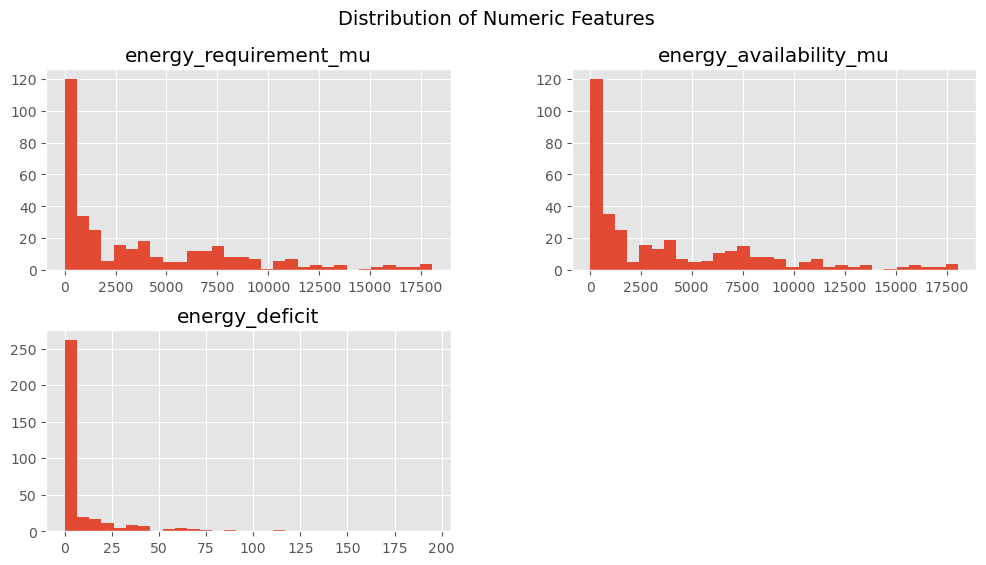

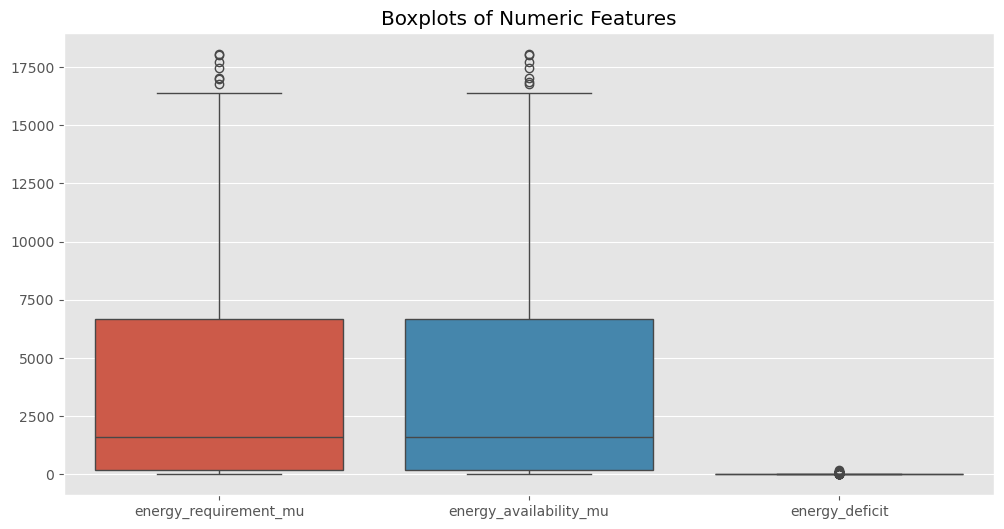

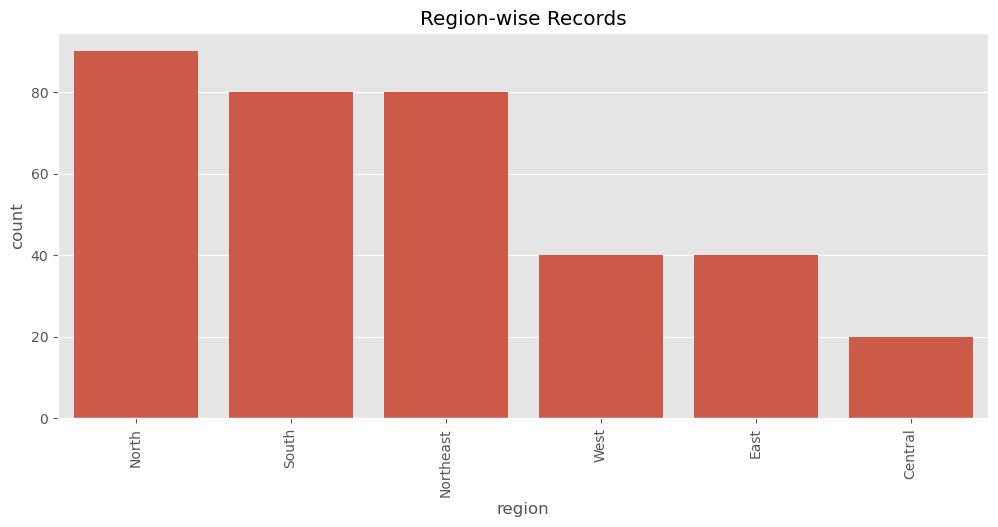

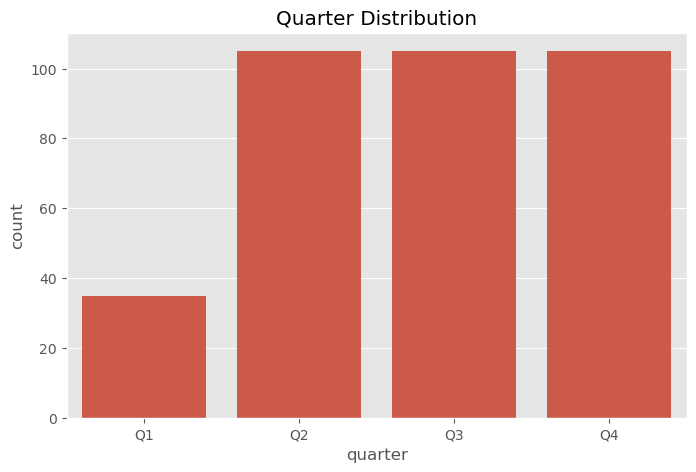

In [14]:
# Histograms of numeric columns
df[['energy_requirement_mu','energy_availability_mu','energy_deficit']].hist(figsize=(12,6), bins=30)
plt.suptitle("Distribution of Numeric Features", fontsize=14)
plt.show()

# Boxplots for outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['energy_requirement_mu','energy_availability_mu','energy_deficit']])
plt.title("Boxplots of Numeric Features")
plt.show()

# Count plots for categorical features
plt.figure(figsize=(12,5))
sns.countplot(data=df, x="region", order=df['region'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Region-wise Records")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="quarter")
plt.title("Quarter Distribution")
plt.show()


4.3 Bivariate Analysis
-

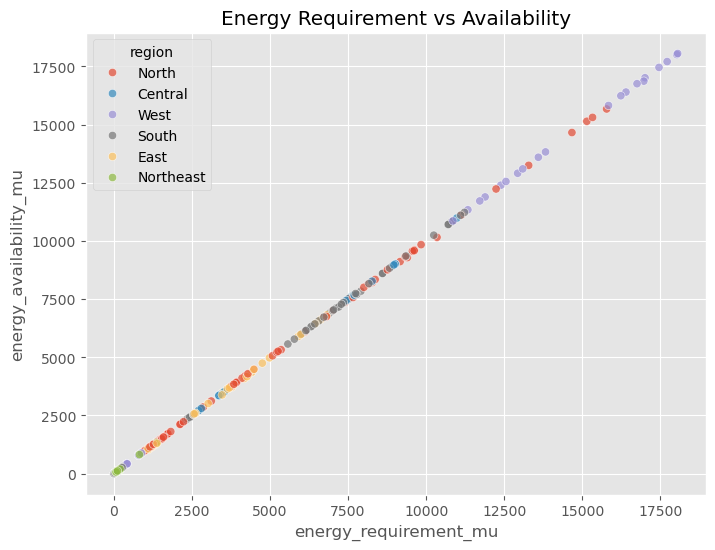

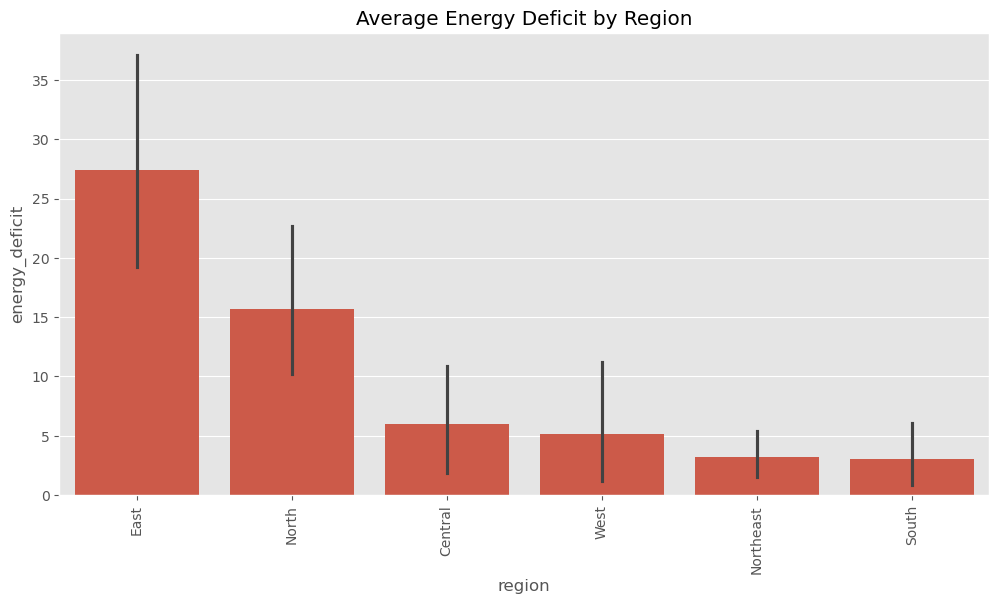

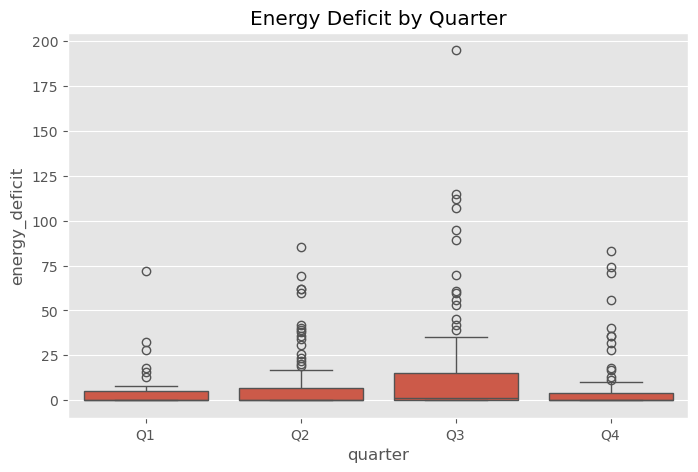

In [15]:
# Requirement vs Availability
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="energy_requirement_mu", y="energy_availability_mu", hue="region", alpha=0.7)
plt.title("Energy Requirement vs Availability")
plt.show()

# Avg Deficit by Region
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="region", y="energy_deficit", estimator=np.mean, order=df.groupby('region')['energy_deficit'].mean().sort_values(ascending=False).index)
plt.xticks(rotation=90)
plt.title("Average Energy Deficit by Region")
plt.show()

# Deficit by Quarter
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="quarter", y="energy_deficit")
plt.title("Energy Deficit by Quarter")
plt.show()


4.3 Correlation Analysis
-

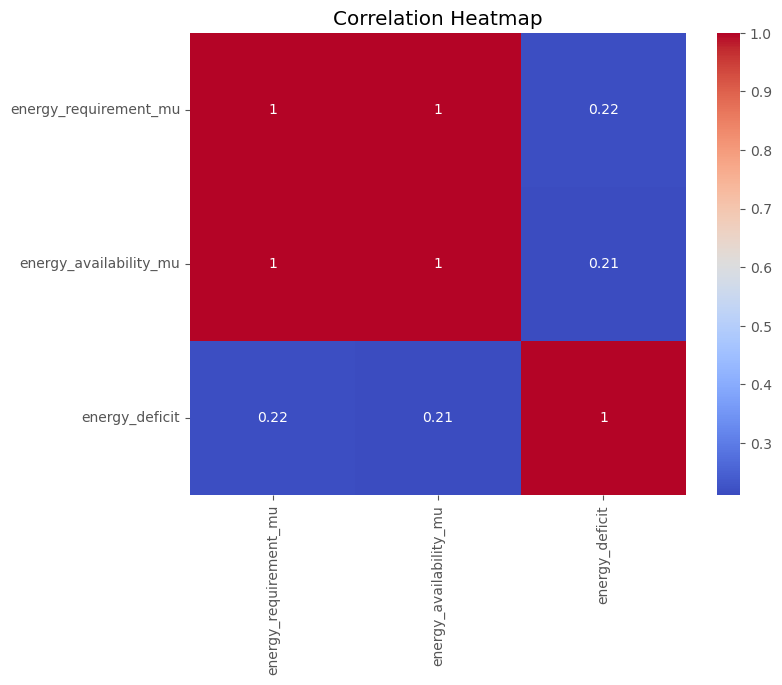

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['energy_requirement_mu','energy_availability_mu','energy_deficit']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


4.4 Time Series Trends
-

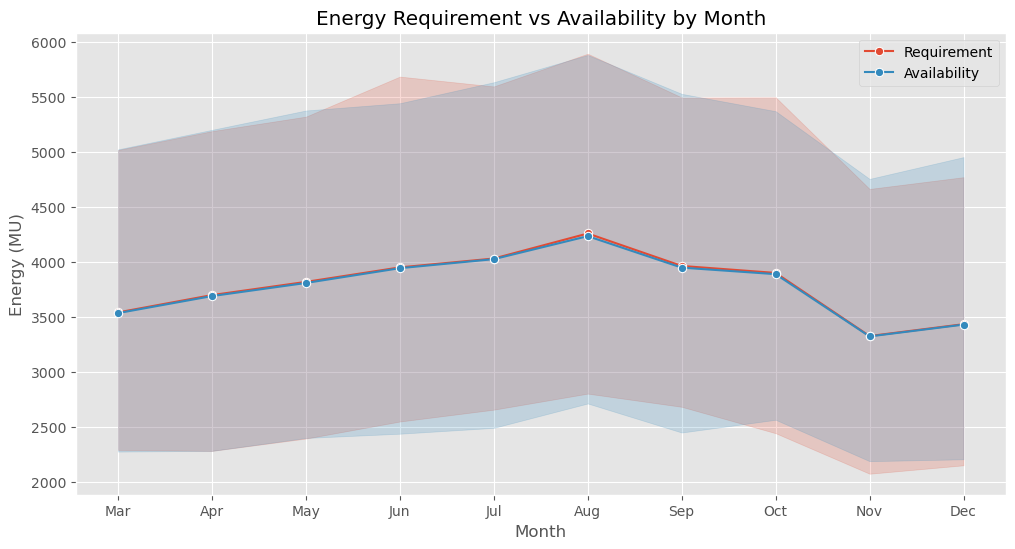

In [17]:
# Ensure month is ordered (Jan to Dec)
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)

# -------------------------------
# 1. Energy Requirement vs Availability (by Month)
# -------------------------------
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="month", y="energy_requirement_mu", label="Requirement", marker="o")
sns.lineplot(data=df, x="month", y="energy_availability_mu", label="Availability", marker="o")
plt.title("Energy Requirement vs Availability by Month")
plt.ylabel("Energy (MU)")
plt.xlabel("Month")
plt.legend()
plt.show()

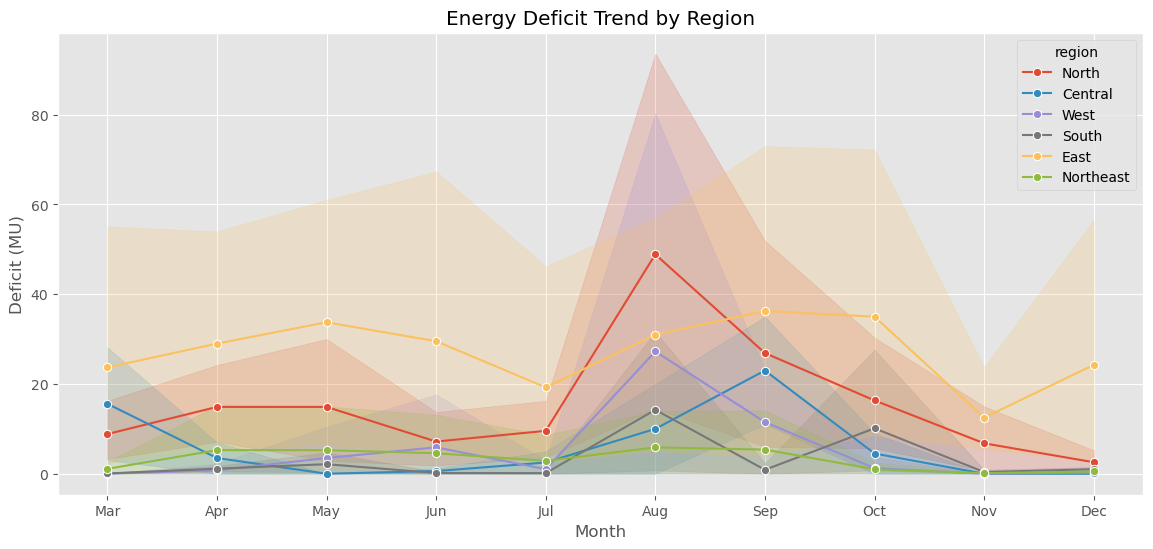

In [18]:
# Energy Deficit by Region (month trend)
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x="month", y="energy_deficit", hue="region", marker="o")
plt.title("Energy Deficit Trend by Region")
plt.ylabel("Deficit (MU)")
plt.xlabel("Month")
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14200\2500834614.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.index, y=top_states.values, palette="viridis")


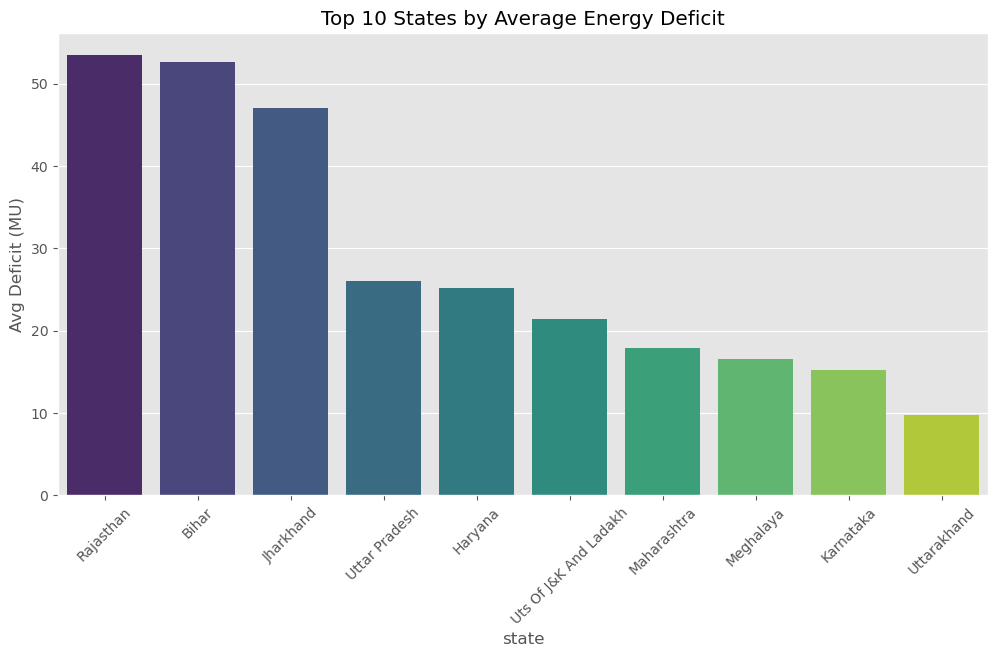

In [19]:
top_states = df.groupby("state")["energy_deficit"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_states.index, y=top_states.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 States by Average Energy Deficit")
plt.ylabel("Avg Deficit (MU)")
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_14200\779376293.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg = df.groupby("month")["energy_deficit"].mean().reindex(df['month'].cat.categories)


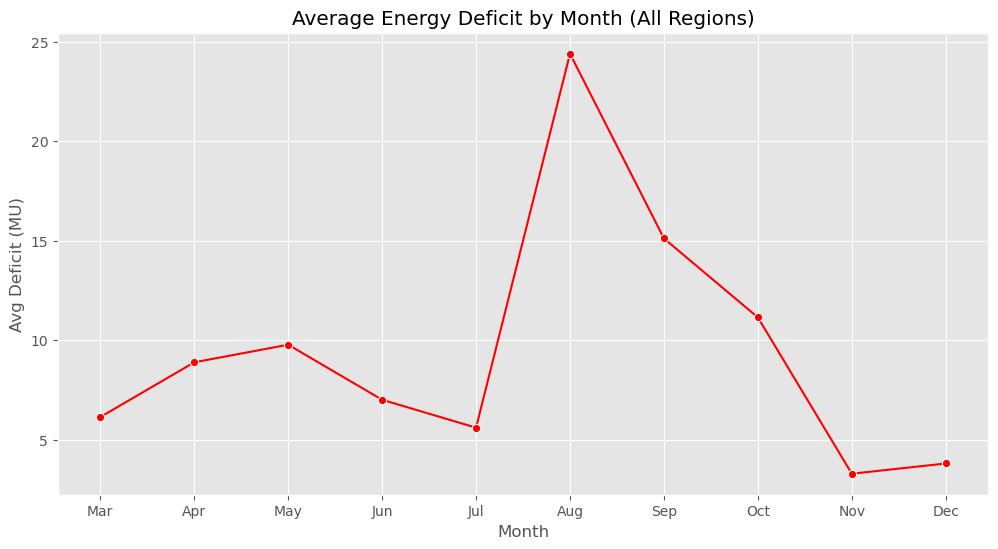

In [20]:
plt.figure(figsize=(12,6))
monthly_avg = df.groupby("month")["energy_deficit"].mean().reindex(df['month'].cat.categories)
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker="o", color="red")
plt.title("Average Energy Deficit by Month (All Regions)")
plt.ylabel("Avg Deficit (MU)")
plt.xlabel("Month")
plt.grid(True)
plt.show()

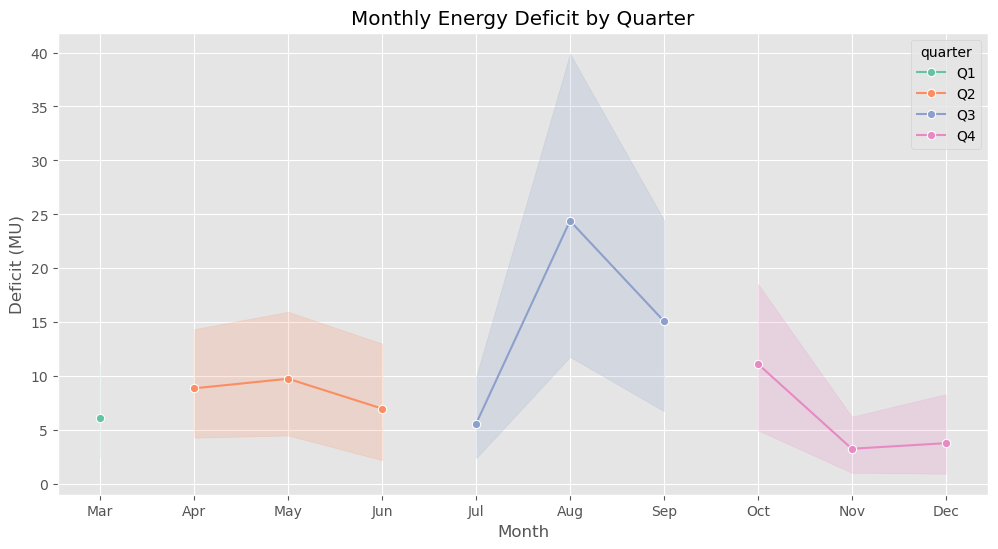

In [21]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="month", y="energy_deficit", hue="quarter", marker="o", palette="Set2")
plt.title("Monthly Energy Deficit by Quarter")
plt.ylabel("Deficit (MU)")
plt.xlabel("Month")
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14200\1379963033.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="region", y="deficit_percent", data=df, estimator=np.mean, palette="coolwarm")


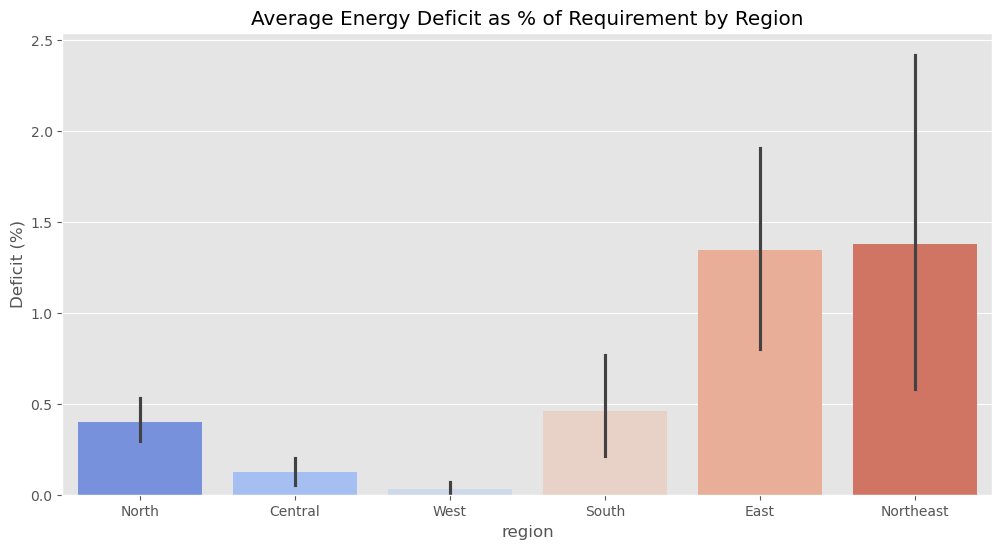

In [22]:
df["deficit_percent"] = df["energy_deficit"] / df["energy_requirement_mu"] * 100

plt.figure(figsize=(12,6))
sns.barplot(x="region", y="deficit_percent", data=df, estimator=np.mean, palette="coolwarm")
plt.title("Average Energy Deficit as % of Requirement by Region")
plt.ylabel("Deficit (%)")
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_14200\2307522149.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_cumsum = df.groupby("month")[["energy_requirement_mu","energy_availability_mu","energy_deficit"]].sum().reindex(month_order).cumsum()


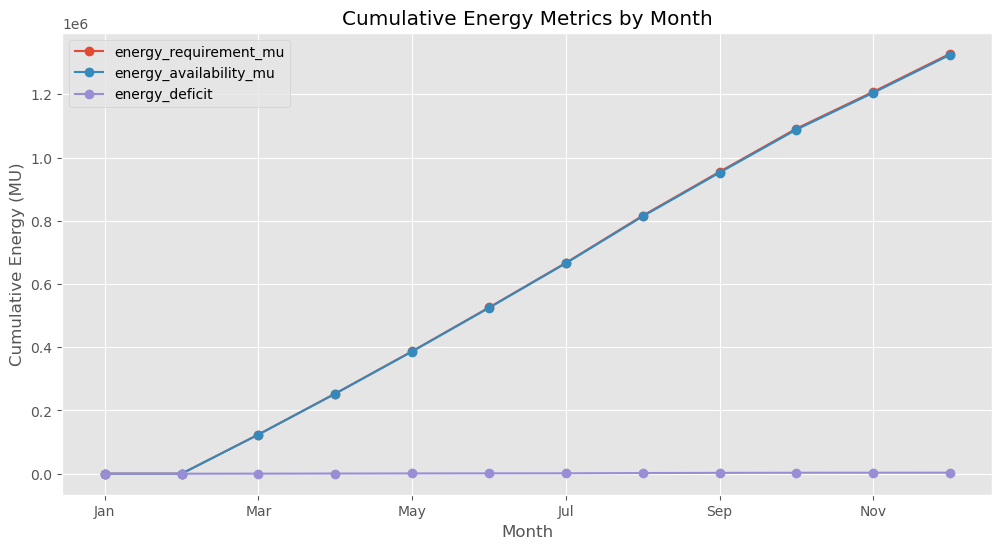

In [23]:
monthly_cumsum = df.groupby("month")[["energy_requirement_mu","energy_availability_mu","energy_deficit"]].sum().reindex(month_order).cumsum()

monthly_cumsum.plot(figsize=(12,6), marker="o")
plt.title("Cumulative Energy Metrics by Month")
plt.ylabel("Cumulative Energy (MU)")
plt.xlabel("Month")
plt.grid(True)
plt.show()


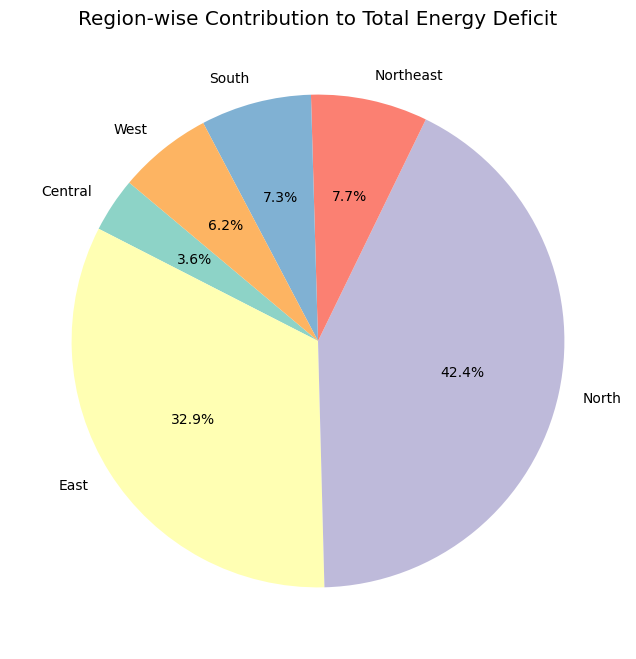

In [24]:
region_deficit = df.groupby("region")["energy_deficit"].sum()
plt.figure(figsize=(8,8))
plt.pie(region_deficit, labels=region_deficit.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title("Region-wise Contribution to Total Energy Deficit")
plt.show()


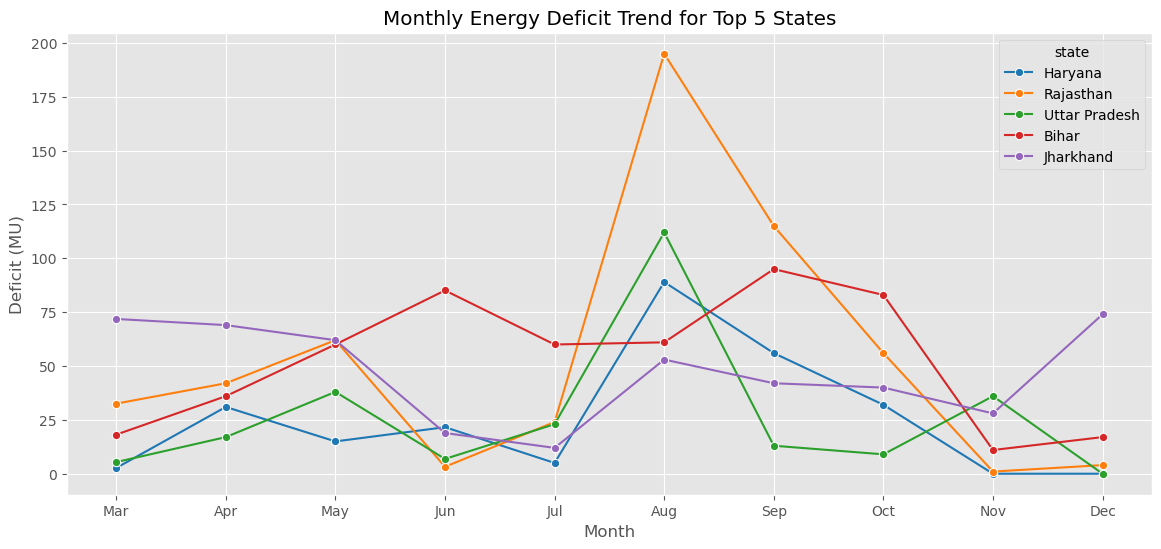

In [25]:
top_states = df.groupby("state")["energy_deficit"].sum().sort_values(ascending=False).head(5).index
plt.figure(figsize=(14,6))
sns.lineplot(data=df[df["state"].isin(top_states)], x="month", y="energy_deficit", hue="state", marker="o", palette="tab10")
plt.title("Monthly Energy Deficit Trend for Top 5 States")
plt.ylabel("Deficit (MU)")
plt.xlabel("Month")
plt.show()


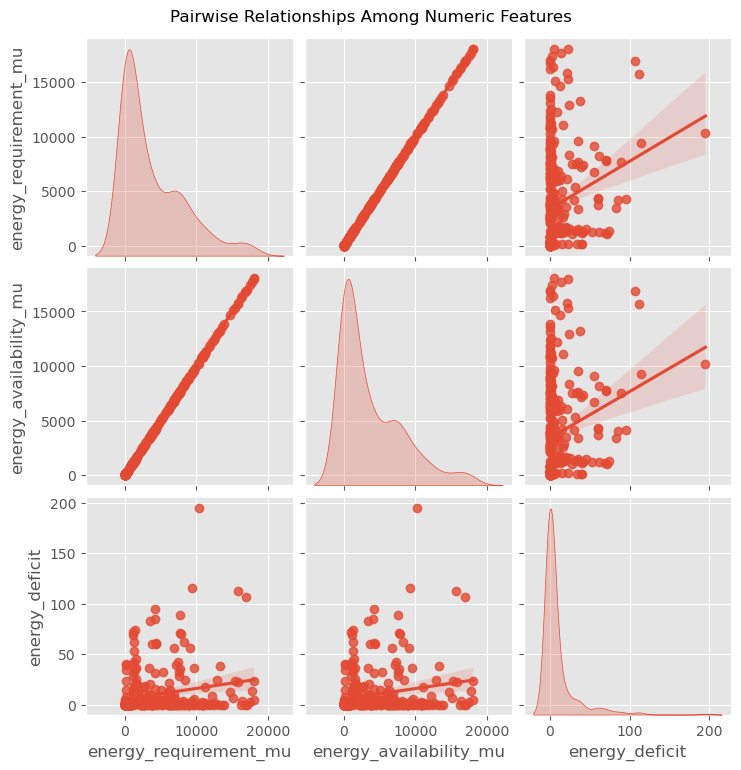

In [26]:
sns.pairplot(df[numeric_cols], kind="reg", diag_kind="kde")
plt.suptitle("Pairwise Relationships Among Numeric Features", y=1.02)
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_14200\176569620.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values="energy_deficit", index="state", columns="month", aggfunc="mean")


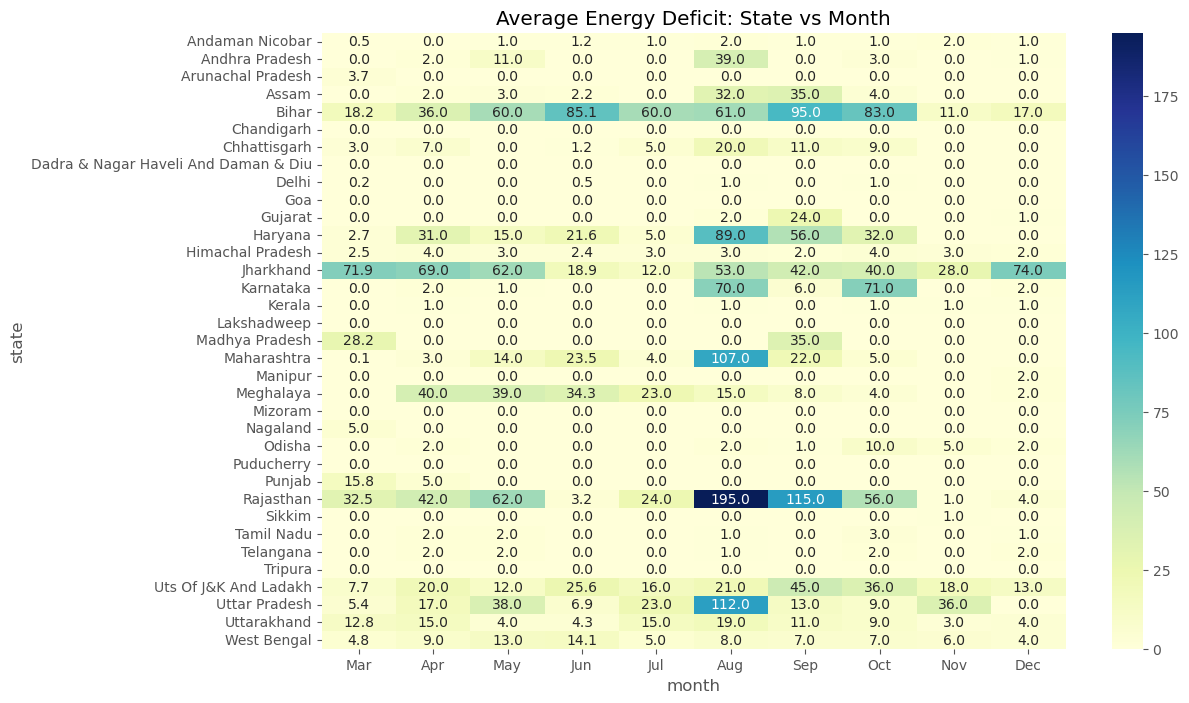

In [27]:
pivot = df.pivot_table(values="energy_deficit", index="state", columns="month", aggfunc="mean")
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average Energy Deficit: State vs Month")
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_14200\3392689047.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values="energy_deficit", index="region", columns="month", aggfunc="mean")


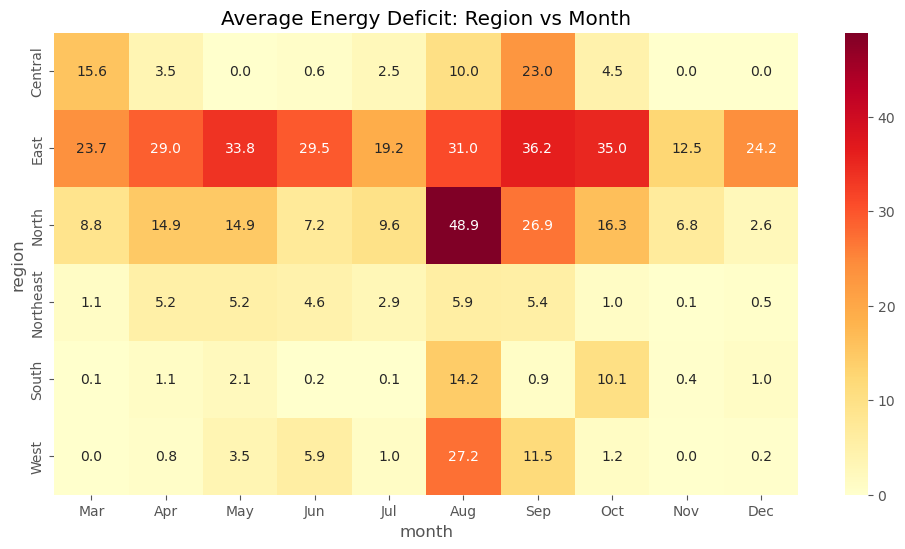

In [28]:
pivot = df.pivot_table(values="energy_deficit", index="region", columns="month", aggfunc="mean")
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Average Energy Deficit: Region vs Month")
plt.show()

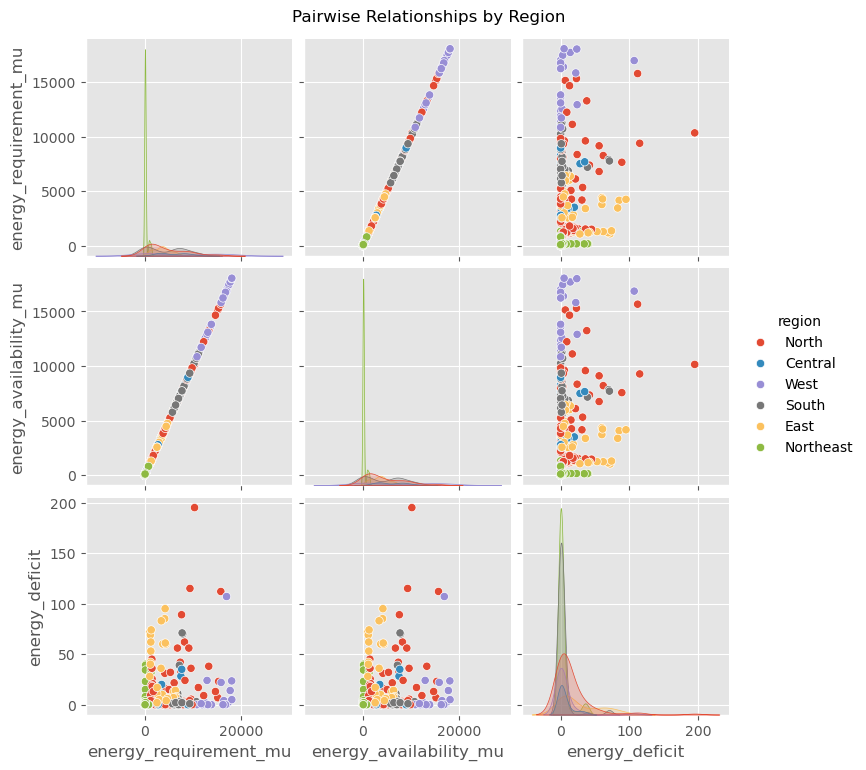

In [29]:
sns.pairplot(df[numeric_cols + ["region"]], hue="region", diag_kind="kde")
plt.suptitle("Pairwise Relationships by Region", y=1.02)
plt.show()


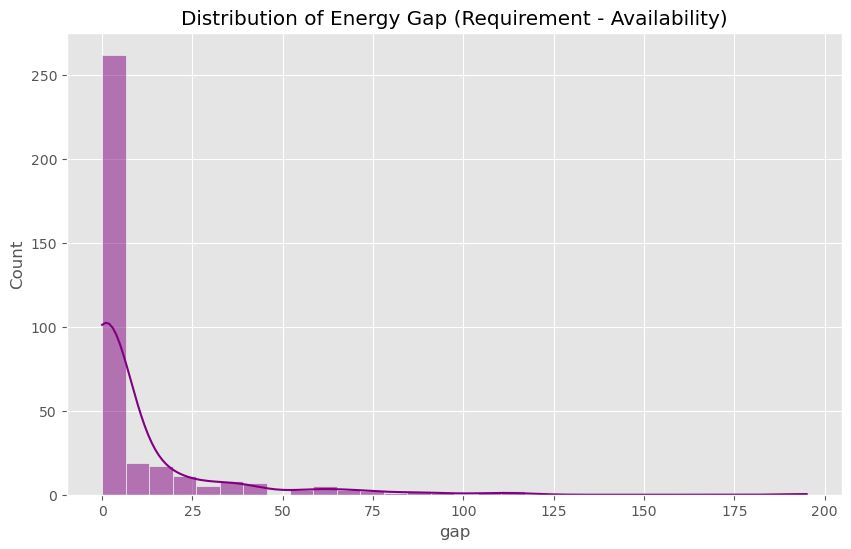

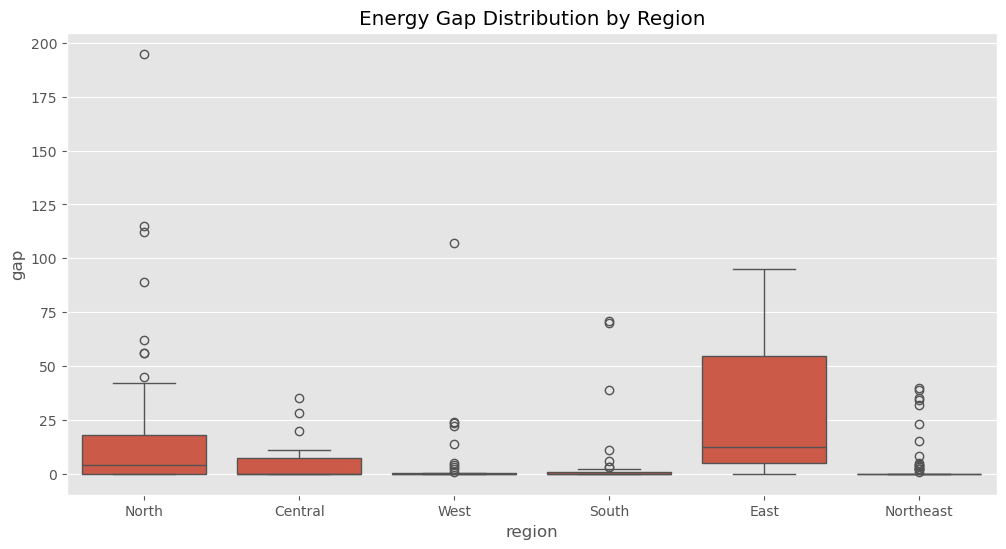

In [30]:
df["gap"] = df["energy_requirement_mu"] - df["energy_availability_mu"]

# Gap histogram
plt.figure(figsize=(10,6))
sns.histplot(df["gap"], bins=30, kde=True, color="purple")
plt.title("Distribution of Energy Gap (Requirement - Availability)")
plt.show()

# Gap by Region
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="region", y="gap")
plt.title("Energy Gap Distribution by Region")
plt.show()


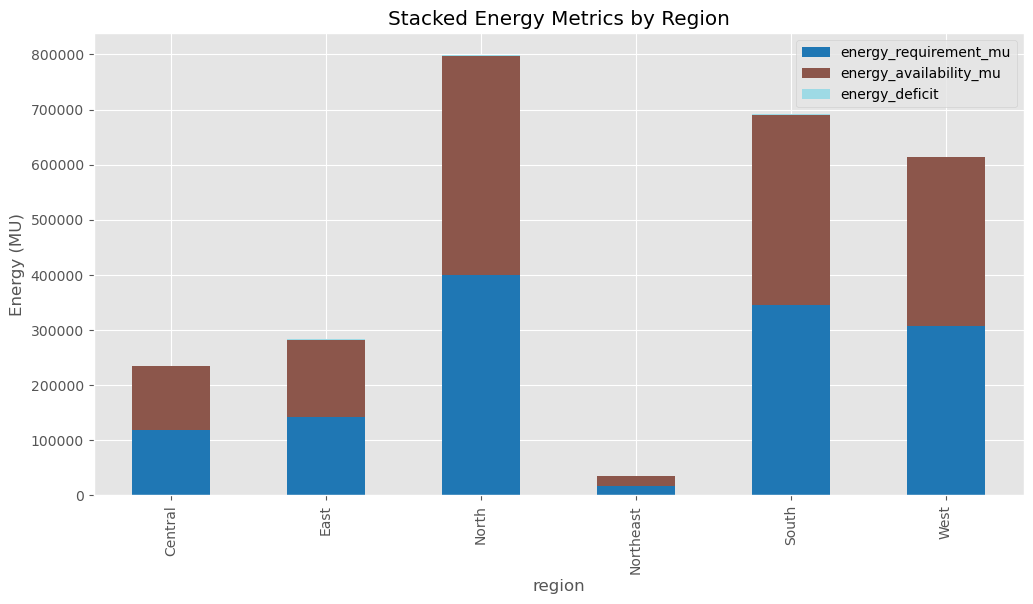

In [31]:
region_sum = df.groupby("region")[["energy_requirement_mu","energy_availability_mu","energy_deficit"]].sum()

region_sum.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
plt.title("Stacked Energy Metrics by Region")
plt.ylabel("Energy (MU)")
plt.show()


4.5 Test for Statistical Properties
-

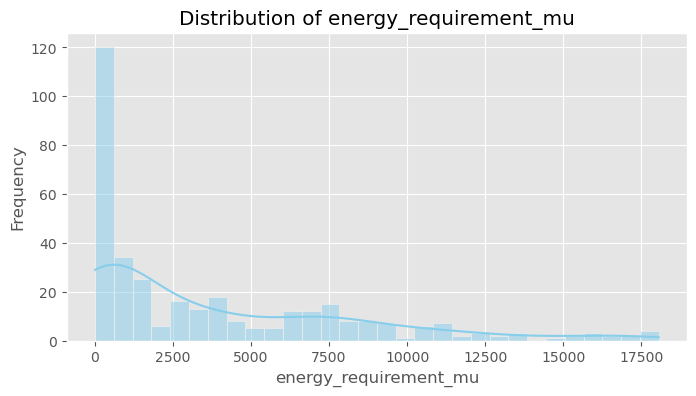

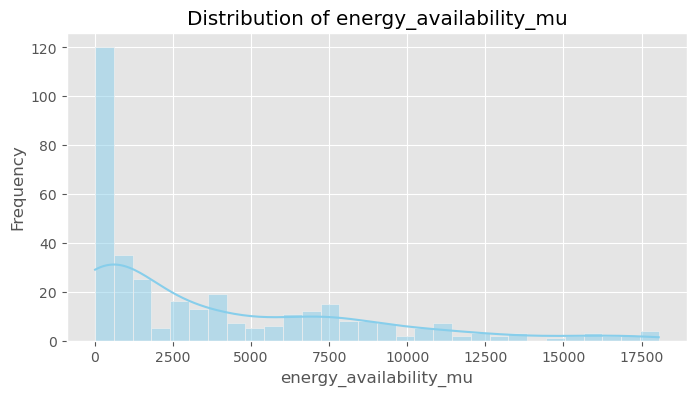

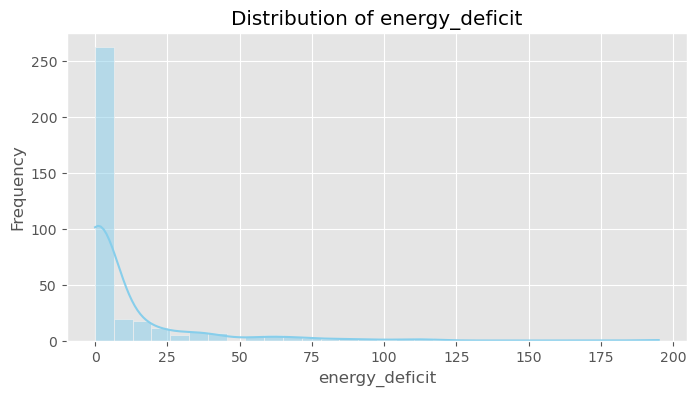

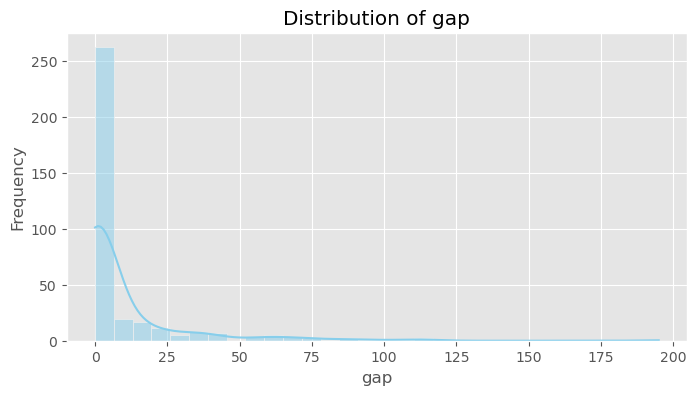

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ["energy_requirement_mu","energy_availability_mu","energy_deficit","gap"]

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


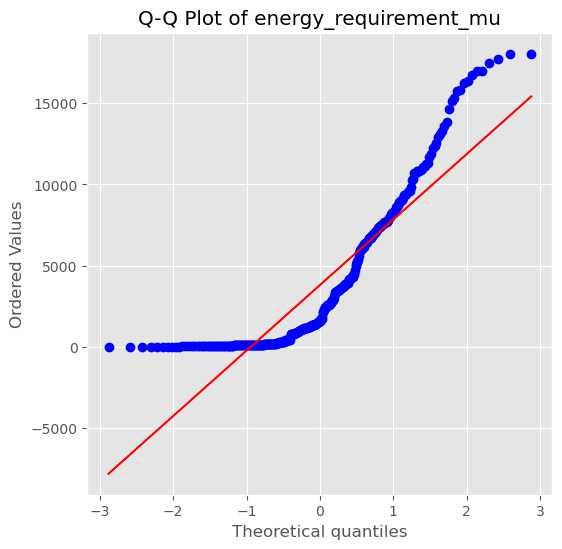

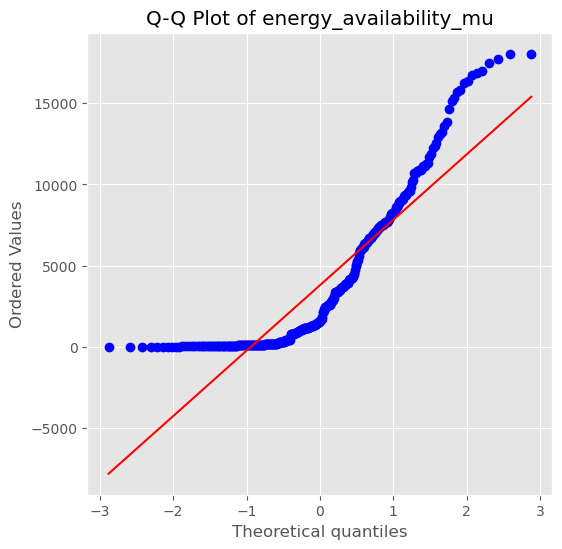

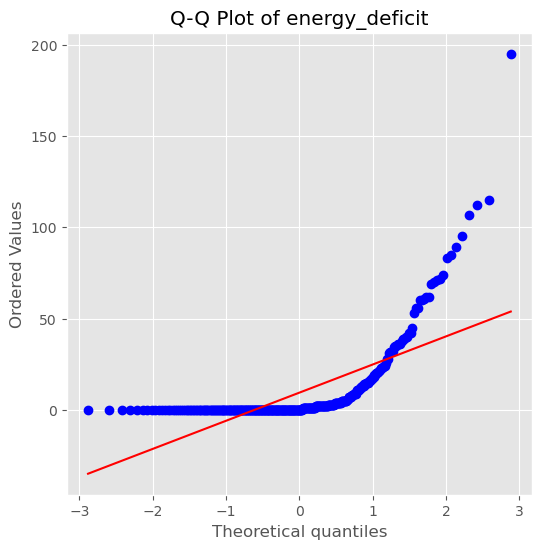

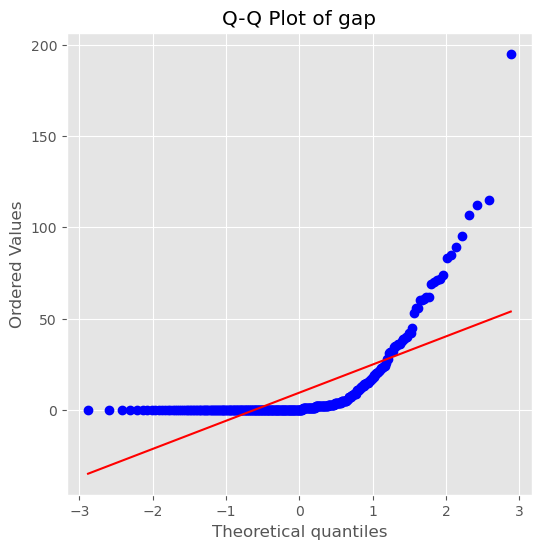

In [33]:
import scipy.stats as stats
import matplotlib.pyplot as plt

for col in numeric_cols:
    plt.figure(figsize=(6,6))
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    plt.show()


In [34]:
from scipy.stats import shapiro

for col in numeric_cols:
    stat, p = shapiro(df[col])
    print(f"{col}: W={stat:.4f}, p={p:.4f}", end=" → ")
    if p > 0.05:
        print("Probably Normal")
    else:
        print("Not Normal")


energy_requirement_mu: W=0.8172, p=0.0000 → Not Normal
energy_availability_mu: W=0.8167, p=0.0000 → Not Normal
energy_deficit: W=0.4973, p=0.0000 → Not Normal
gap: W=0.4973, p=0.0000 → Not Normal


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot predicted vs actual
def plot_predicted_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7, color="blue")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)  # perfect fit line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(True)
    plt.show()

5: Prepare dataset
-

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

plt.style.use("ggplot")

# Load dataset
df = pd.read_csv("cleaned_dataset.csv")

# Create additional columns
df["gap"] = df["energy_requirement_mu"] - df["energy_availability_mu"]
df["deficit_flag"] = (df["energy_deficit"] > 0).astype(int)

# Optional: preview
df.head()


,region,state,is_union_territory,month,quarter,energy_requirement_mu,energy_availability_mu,energy_deficit,gap,deficit_flag
0,North,Chandigarh,True,Mar,Q1,101.600,101.600,0.000,0.000,0
1,North,Delhi,True,Mar,Q1,2130.478,2130.279,0.199,0.199,1
2,North,Haryana,False,Mar,Q1,3911.822,3909.160,2.662,2.662,1
3,North,Himachal Pradesh,False,Mar,Q1,1025.630,1023.160,2.470,2.470,1
4,North,Uts Of J&K And Ladakh,True,Mar,Q1,1725.610,1717.930,7.680,7.680,1


5.1 Preprocessing for Base & Seasonality Models
-

In [37]:
# Base features
base_features = ["energy_requirement_mu", "energy_availability_mu", "gap"]  # remove target

# Seasonality features: numeric + one-hot month/quarter
season_features_numeric = base_features
season_features_cat = ["month","quarter"]

# One-hot encode categorical columns for seasonality
df_season = pd.get_dummies(df[season_features_numeric + season_features_cat], drop_first=True)

# Base X
X_base = df[base_features].values
y_class = df["deficit_flag"].values
y_reg = df["energy_deficit"].values

# Seasonality X
X_season = df_season.values

# Train-Test Split
from sklearn.model_selection import train_test_split

# Base
X_train_base_clf, X_test_base_clf, y_train_clf, y_test_clf = train_test_split(X_base, y_class, test_size=0.3, random_state=42)
X_train_base_reg, X_test_base_reg, y_train_reg, y_test_reg = train_test_split(X_base, y_reg, test_size=0.3, random_state=42)

# Seasonality
X_train_season_clf, X_test_season_clf, _, _ = train_test_split(X_season, y_class, test_size=0.3, random_state=42)
X_train_season_reg, X_test_season_reg, _, _ = train_test_split(X_season, y_reg, test_size=0.3, random_state=42)


6: Machine Learning Models
-

6.1: KNN Classifier (Base vs Seasonality)
-

KNN Base Accuracy: 0.829
KNN Seasonality Accuracy: 0.829


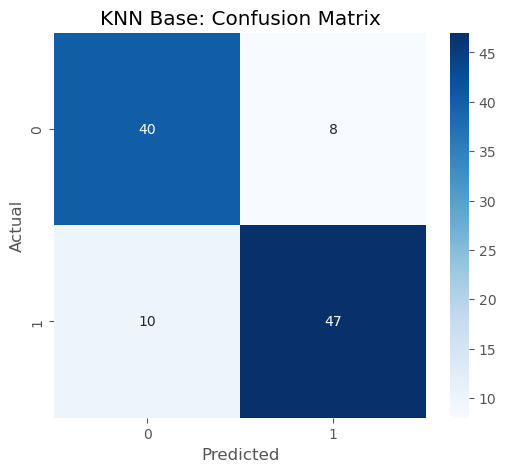

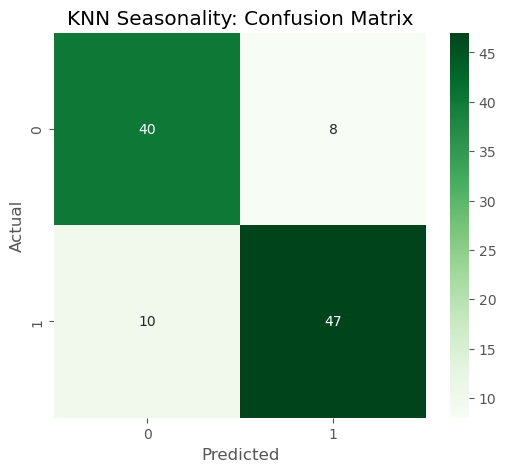

C:\Users\HP\AppData\Local\Temp\ipykernel_14200\340380061.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="coolwarm")


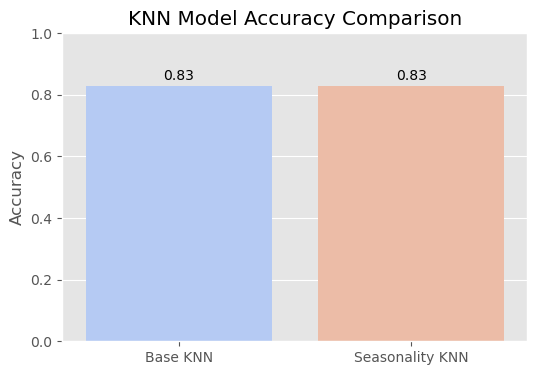

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Base KNN
knn_base = KNeighborsClassifier(n_neighbors=5)
knn_base.fit(X_train_base_clf, y_train_clf)
y_pred_knn_base = knn_base.predict(X_test_base_clf)
print("KNN Base Accuracy:", round(accuracy_score(y_test_clf, y_pred_knn_base), 3))

# Seasonality KNN
knn_season = KNeighborsClassifier(n_neighbors=5)
knn_season.fit(X_train_season_clf, y_train_clf)
y_pred_knn_season = knn_season.predict(X_test_season_clf)
print("KNN Seasonality Accuracy:", round(accuracy_score(y_test_clf, y_pred_knn_season), 3))


# -------------------------------
# Confusion Matrix: Base KNN
# -------------------------------
cm_base = confusion_matrix(y_test_clf, y_pred_knn_base)
plt.figure(figsize=(6,5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues')
plt.title("KNN Base: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# Confusion Matrix: Seasonality KNN
# -------------------------------
cm_season = confusion_matrix(y_test_clf, y_pred_knn_season)
plt.figure(figsize=(6,5))
sns.heatmap(cm_season, annot=True, fmt='d', cmap='Greens')
plt.title("KNN Seasonality: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# Accuracy Comparison
# -------------------------------
accuracies = [accuracy_score(y_test_clf, y_pred_knn_base), 
              accuracy_score(y_test_clf, y_pred_knn_season)]
labels = ["Base KNN", "Seasonality KNN"]

plt.figure(figsize=(6,4))
sns.barplot(x=labels, y=accuracies, palette="coolwarm")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("KNN Model Accuracy Comparison")
for i, v in enumerate(accuracies):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.show()


6.2: Naive Bayes (Base vs Seasonality)
-

Naive Bayes Base Accuracy: 1.0
Naive Bayes Seasonality Accuracy: 1.0


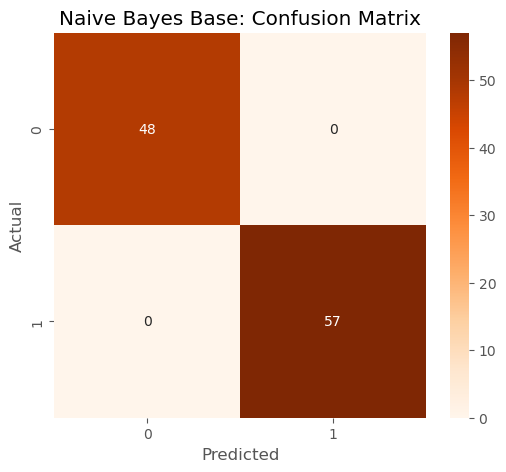

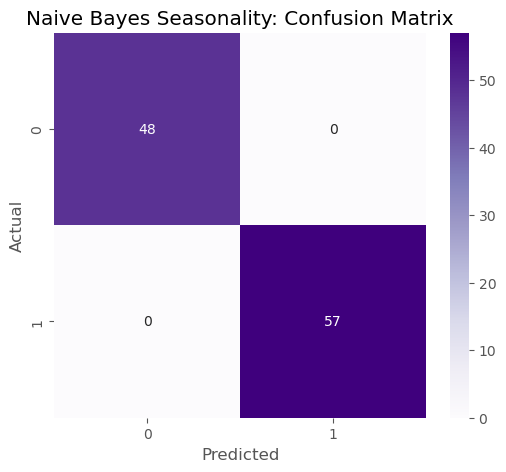

C:\Users\HP\AppData\Local\Temp\ipykernel_14200\2537523909.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_nb, y=accuracies_nb, palette="Set2")


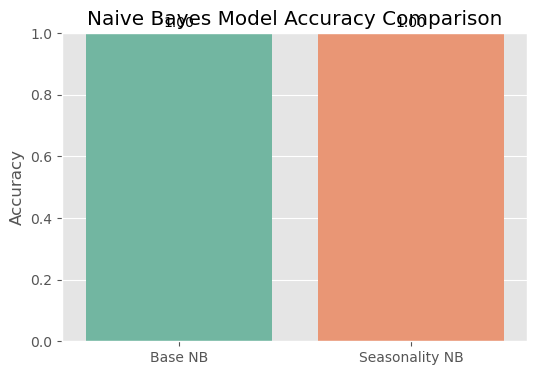

In [39]:
# Base Naive Bayes
nb_base = GaussianNB()
nb_base.fit(X_train_base_clf, y_train_clf)
y_pred_nb_base = nb_base.predict(X_test_base_clf)
print("Naive Bayes Base Accuracy:", round(accuracy_score(y_test_clf, y_pred_nb_base), 3))

# Seasonality Naive Bayes
nb_season = GaussianNB()
nb_season.fit(X_train_season_clf, y_train_clf)
y_pred_nb_season = nb_season.predict(X_test_season_clf)
print("Naive Bayes Seasonality Accuracy:", round(accuracy_score(y_test_clf, y_pred_nb_season), 3))

# -------------------------------
# Confusion Matrix: Base Naive Bayes
# -------------------------------
cm_nb_base = confusion_matrix(y_test_clf, y_pred_nb_base)
plt.figure(figsize=(6,5))
sns.heatmap(cm_nb_base, annot=True, fmt='d', cmap='Oranges')
plt.title("Naive Bayes Base: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# Confusion Matrix: Seasonality Naive Bayes
# -------------------------------
cm_nb_season = confusion_matrix(y_test_clf, y_pred_nb_season)
plt.figure(figsize=(6,5))
sns.heatmap(cm_nb_season, annot=True, fmt='d', cmap='Purples')
plt.title("Naive Bayes Seasonality: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# Accuracy Comparison
# -------------------------------
accuracies_nb = [accuracy_score(y_test_clf, y_pred_nb_base), 
                 accuracy_score(y_test_clf, y_pred_nb_season)]
labels_nb = ["Base NB", "Seasonality NB"]

plt.figure(figsize=(6,4))
sns.barplot(x=labels_nb, y=accuracies_nb, palette="Set2")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Naive Bayes Model Accuracy Comparison")
for i, v in enumerate(accuracies_nb):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.show()


6.3: Logistic Regression (Base vs Seasonality)
-

Logistic Regression Base Accuracy: 1.0
Logistic Regression Seasonality Accuracy: 1.0


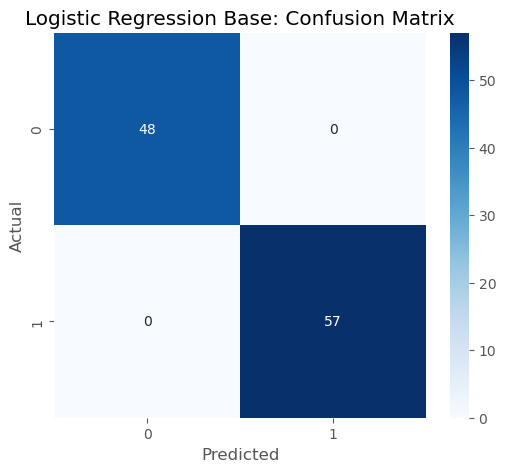

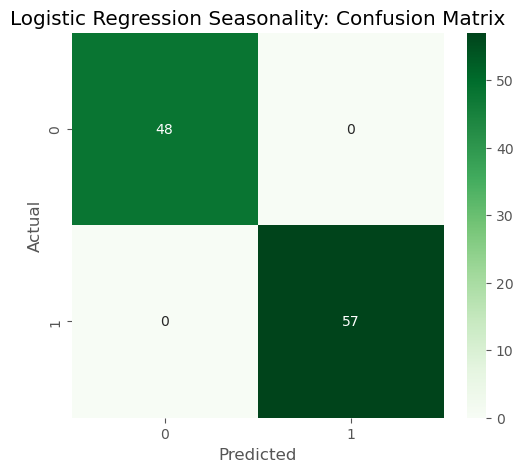

C:\Users\HP\AppData\Local\Temp\ipykernel_14200\2220428764.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_log, y=accuracies_log, palette="Set1")


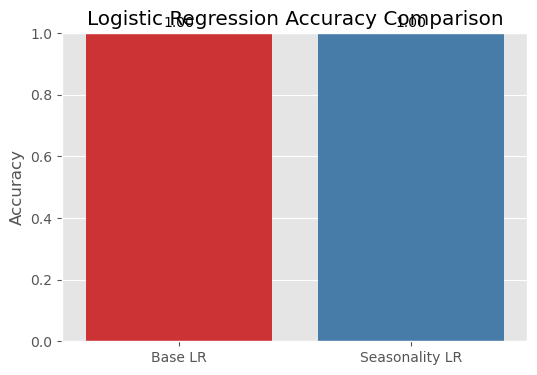

In [40]:
# Base Logistic Regression
log_base = LogisticRegression(max_iter=1000)
log_base.fit(X_train_base_clf, y_train_clf)
y_pred_log_base = log_base.predict(X_test_base_clf)
print("Logistic Regression Base Accuracy:", round(accuracy_score(y_test_clf, y_pred_log_base), 3))

# Seasonality Logistic Regression
log_season = LogisticRegression(max_iter=1000)
log_season.fit(X_train_season_clf, y_train_clf)
y_pred_log_season = log_season.predict(X_test_season_clf)
print("Logistic Regression Seasonality Accuracy:", round(accuracy_score(y_test_clf, y_pred_log_season), 3))

# -------------------------------
# Confusion Matrix: Base Logistic Regression
# -------------------------------
cm_log_base = confusion_matrix(y_test_clf, y_pred_log_base)
plt.figure(figsize=(6,5))
sns.heatmap(cm_log_base, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Base: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# Confusion Matrix: Seasonality Logistic Regression
# -------------------------------
cm_log_season = confusion_matrix(y_test_clf, y_pred_log_season)
plt.figure(figsize=(6,5))
sns.heatmap(cm_log_season, annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Seasonality: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# Accuracy Comparison
# -------------------------------
accuracies_log = [accuracy_score(y_test_clf, y_pred_log_base), 
                  accuracy_score(y_test_clf, y_pred_log_season)]
labels_log = ["Base LR", "Seasonality LR"]

plt.figure(figsize=(6,4))
sns.barplot(x=labels_log, y=accuracies_log, palette="Set1")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy Comparison")
for i, v in enumerate(accuracies_log):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.show()


6.4: Linear Regression (Base vs Seasonality)
-

Linear Regression Base RMSE: 0.0
Linear Regression Base R²: 1.0
Linear Regression Seasonality RMSE: 0.0
Linear Regression Seasonality R²: 1.0


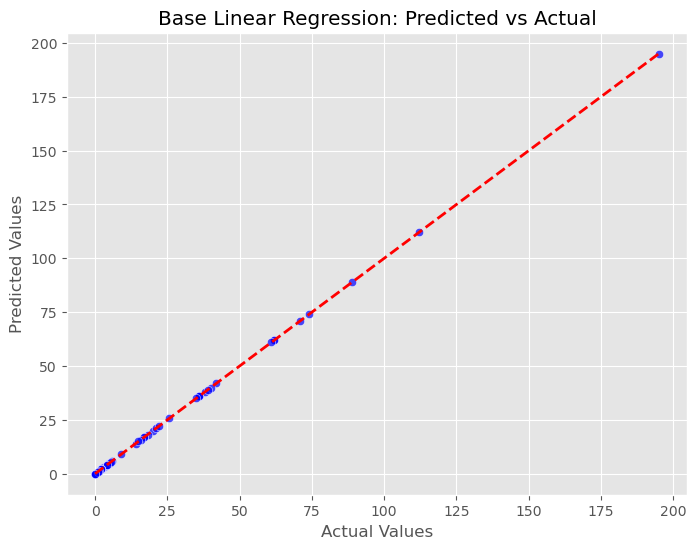

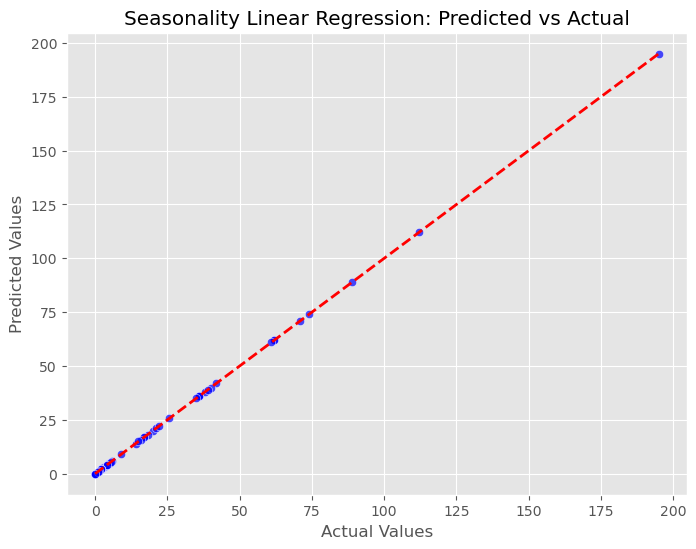

In [41]:
# -------------------------------
# Base Linear Regression
# -------------------------------
lr_base = LinearRegression()
lr_base.fit(X_train_base_reg, y_train_reg)
y_pred_lr_base = lr_base.predict(X_test_base_reg)

# Manual RMSE calculation
mse_base = mean_squared_error(y_test_reg, y_pred_lr_base)
rmse_base = np.sqrt(mse_base)
r2_base = r2_score(y_test_reg, y_pred_lr_base)

print("Linear Regression Base RMSE:", round(rmse_base, 3))
print("Linear Regression Base R²:", round(r2_base, 3))

# -------------------------------
# Seasonality Linear Regression
# -------------------------------
lr_season = LinearRegression()
lr_season.fit(X_train_season_reg, y_train_reg)
y_pred_lr_season = lr_season.predict(X_test_season_reg)

# Manual RMSE calculation
mse_season = mean_squared_error(y_test_reg, y_pred_lr_season)
rmse_season = np.sqrt(mse_season)
r2_season = r2_score(y_test_reg, y_pred_lr_season)

print("Linear Regression Seasonality RMSE:", round(rmse_season, 3))
print("Linear Regression Seasonality R²:", round(r2_season, 3))

plot_predicted_vs_actual(y_test_reg, y_pred_lr_base, "Base Linear Regression: Predicted vs Actual")

plot_predicted_vs_actual(y_test_reg, y_pred_lr_season, "Seasonality Linear Regression: Predicted vs Actual")

6.5: K-Means Clustering (Base vs Seasonality)
-

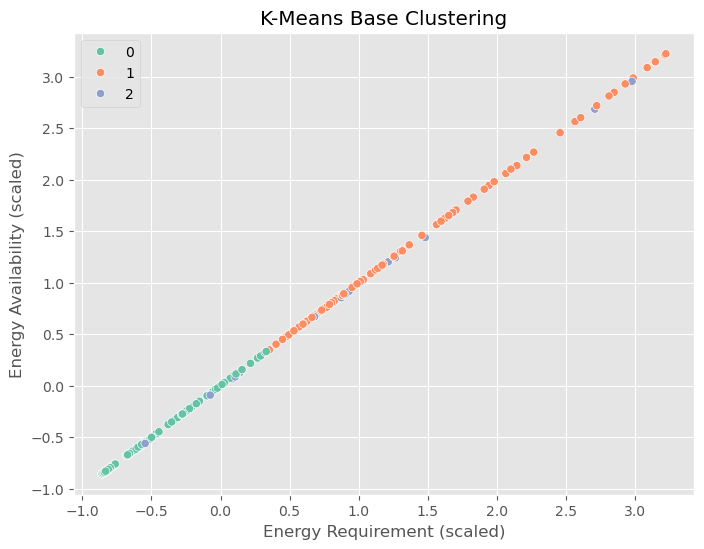

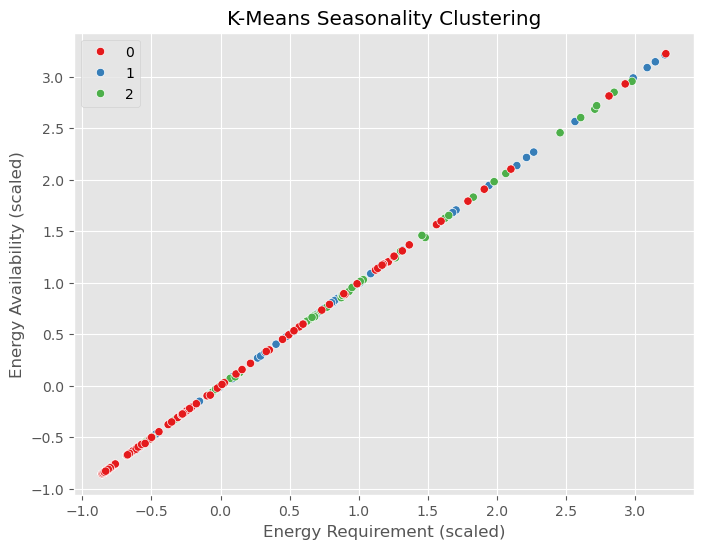

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1️⃣ Feature Scaling
# ----------------------------

scaler_base = StandardScaler()
X_base_scaled = scaler_base.fit_transform(X_base)

scaler_season = StandardScaler()
X_season_scaled = scaler_season.fit_transform(X_season)

# ----------------------------
# 2️⃣ Base K-Means
# ----------------------------

kmeans_base = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_base = kmeans_base.fit_predict(X_base_scaled)
df["cluster_base"] = clusters_base

# ----------------------------
# 3️⃣ Seasonality K-Means
# ----------------------------

kmeans_season = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_season = kmeans_season.fit_predict(X_season_scaled)
df["cluster_season"] = clusters_season

# ----------------------------
# 4️⃣ Visualization
# ----------------------------

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_base_scaled[:,0], y=X_base_scaled[:,1], hue=clusters_base, palette="Set2")
plt.title("K-Means Base Clustering")
plt.xlabel("Energy Requirement (scaled)")
plt.ylabel("Energy Availability (scaled)")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_season_scaled[:,0], y=X_season_scaled[:,1], hue=clusters_season, palette="Set1")
plt.title("K-Means Seasonality Clustering")
plt.xlabel("Energy Requirement (scaled)")
plt.ylabel("Energy Availability (scaled)")
plt.show()


SVM (Support Vector Machine) (Base & Seasonality)
-

SVM Base Model Accuracy: 0.648
SVM Seasonality Model Accuracy: 0.629


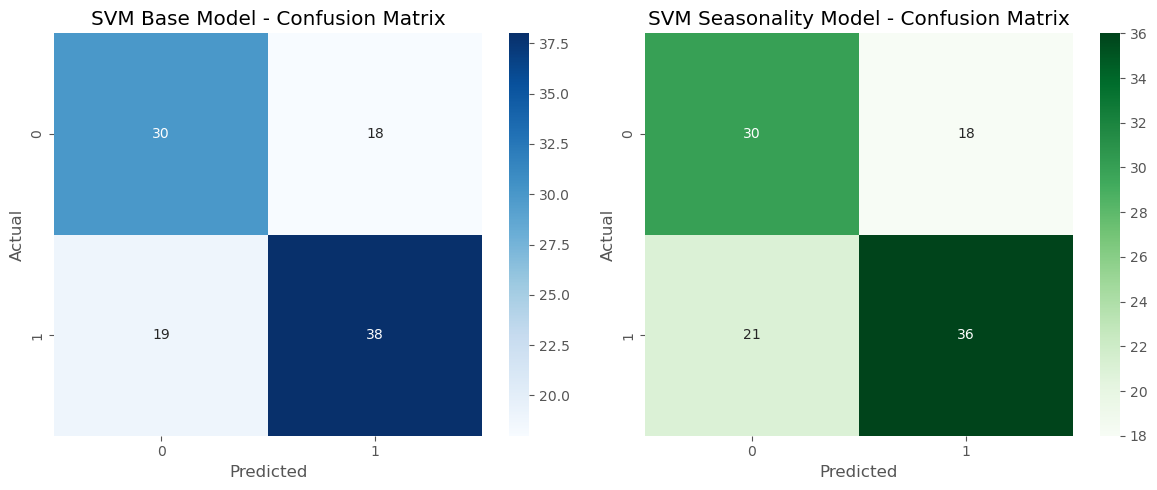

C:\Users\HP\AppData\Local\Temp\ipykernel_14200\3497053155.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


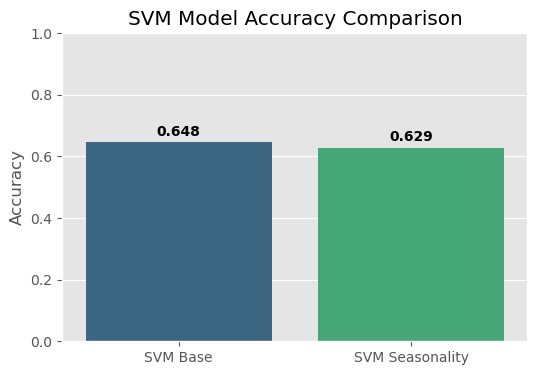

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Base SVM Model
# -----------------------------
svm_base = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_base.fit(X_train_base_clf, y_train_clf)

y_pred_svm_base = svm_base.predict(X_test_base_clf)
acc_svm_base = round(accuracy_score(y_test_clf, y_pred_svm_base), 3)
print("SVM Base Model Accuracy:", acc_svm_base)


# -----------------------------
# Seasonality SVM Model
# -----------------------------
svm_season = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_season.fit(X_train_season_clf, y_train_clf)

y_pred_svm_season = svm_season.predict(X_test_season_clf)
acc_svm_season = round(accuracy_score(y_test_clf, y_pred_svm_season), 3)
print("SVM Seasonality Model Accuracy:", acc_svm_season)


# -----------------------------
# Confusion Matrix Visualization
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_clf, y_pred_svm_base), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('SVM Base Model - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test_clf, y_pred_svm_season), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('SVM Seasonality Model - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# -----------------------------
# Accuracy Comparison Plot
# -----------------------------
models = ['SVM Base', 'SVM Seasonality']
accuracies = [acc_svm_base, acc_svm_season]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title("SVM Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, str(v), ha='center', fontweight='bold')
plt.show()


Random Forest (Base & Seasonality)
-

Random Forest Base Model Accuracy: 1.0
Random Forest Seasonality Model Accuracy: 1.0


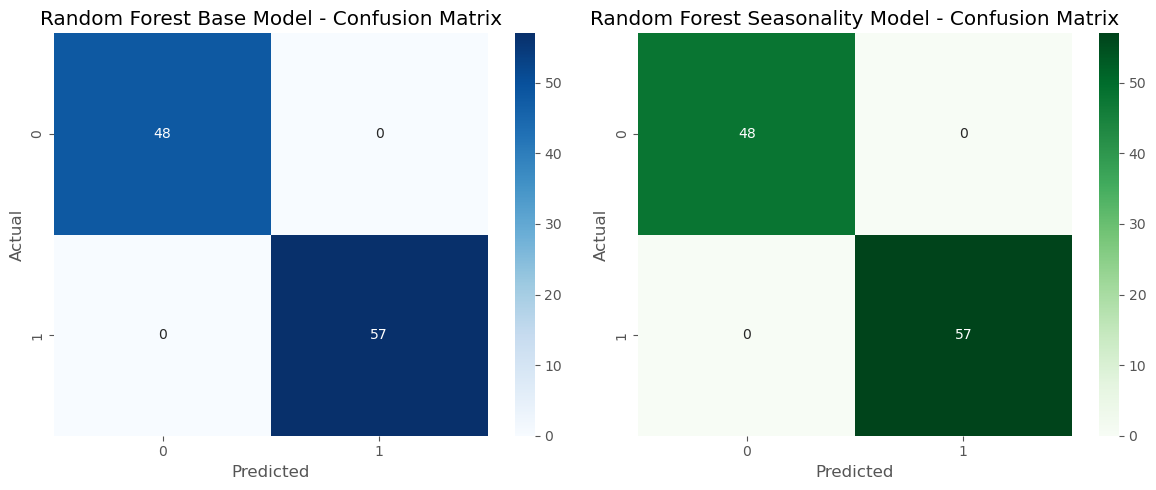

C:\Users\HP\AppData\Local\Temp\ipykernel_14200\3293399346.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='mako')


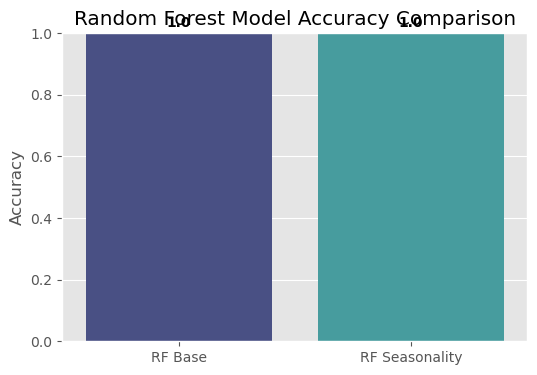

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Base Random Forest Model
# -----------------------------
rf_base = RandomForestClassifier(
    n_estimators=200,       # Number of trees
    max_depth=None,         # No depth limit
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)
rf_base.fit(X_train_base_clf, y_train_clf)

y_pred_rf_base = rf_base.predict(X_test_base_clf)
acc_rf_base = round(accuracy_score(y_test_clf, y_pred_rf_base), 3)
print("Random Forest Base Model Accuracy:", acc_rf_base)


# -----------------------------
# Seasonality Random Forest Model
# -----------------------------
rf_season = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_season.fit(X_train_season_clf, y_train_clf)

y_pred_rf_season = rf_season.predict(X_test_season_clf)
acc_rf_season = round(accuracy_score(y_test_clf, y_pred_rf_season), 3)
print("Random Forest Seasonality Model Accuracy:", acc_rf_season)


# -----------------------------
# Confusion Matrix Visualization
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_clf, y_pred_rf_base), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Base Model - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test_clf, y_pred_rf_season), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest Seasonality Model - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# -----------------------------
# Accuracy Comparison Plot
# -----------------------------
models = ['RF Base', 'RF Seasonality']
accuracies = [acc_rf_base, acc_rf_season]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies, palette='mako')
plt.title("Random Forest Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, str(v), ha='center', fontweight='bold')
plt.show()


Decision Tree (Base & Seasonality)
-

Decision Tree Base Model Accuracy: 1.0
Decision Tree Seasonality Model Accuracy: 1.0


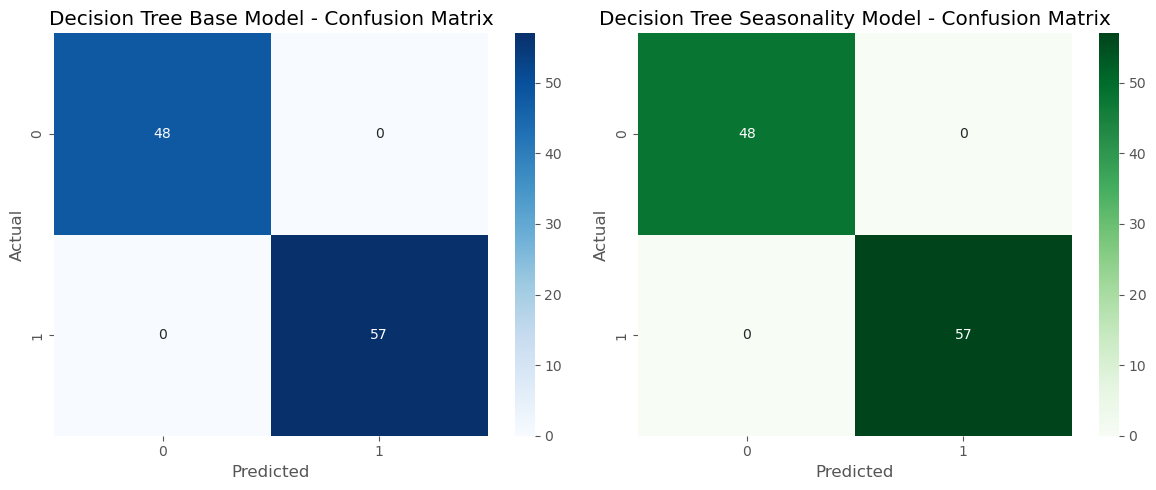

C:\Users\HP\AppData\Local\Temp\ipykernel_14200\2377165417.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='cool')


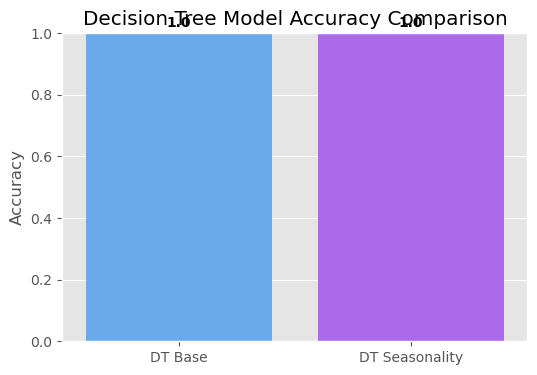

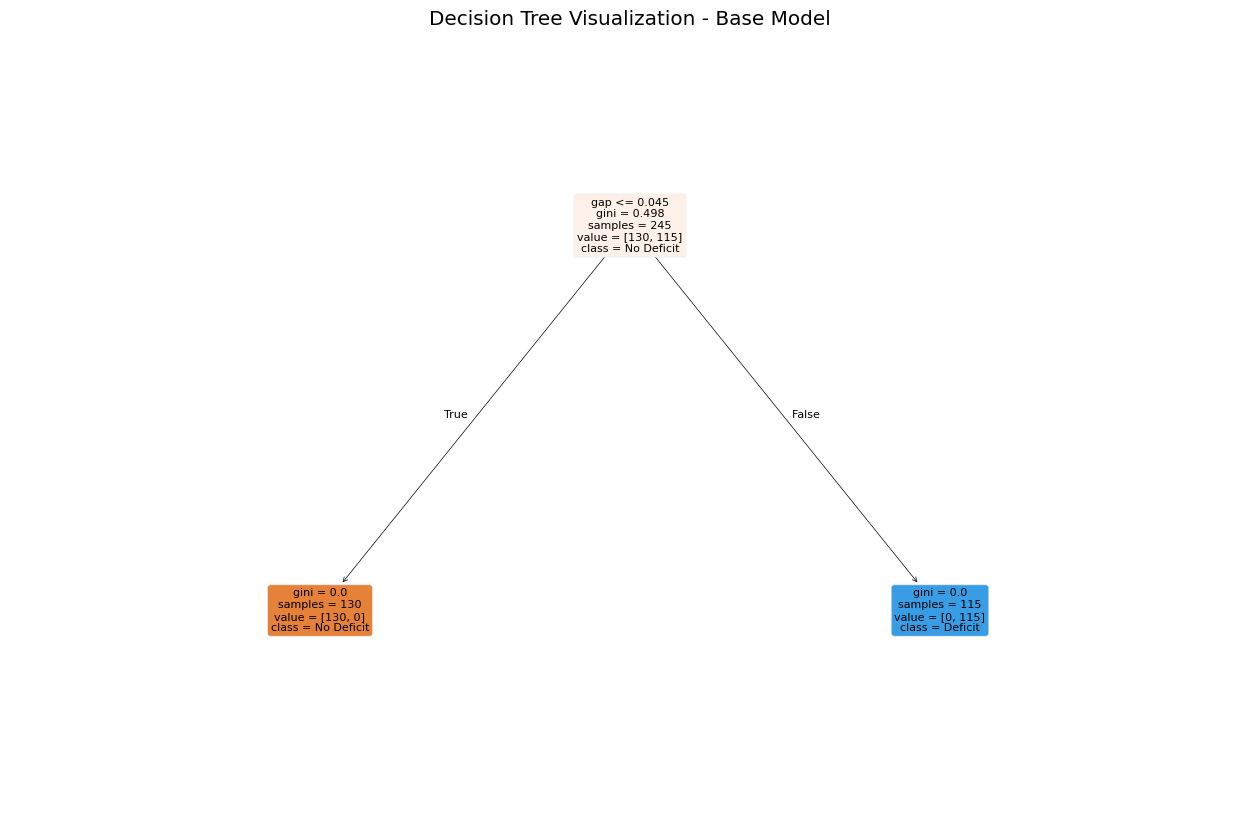

In [45]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Base Decision Tree Model
# -----------------------------
dt_base = DecisionTreeClassifier(
    criterion='gini',     # Split quality metric (can use 'entropy' for information gain)
    max_depth=None,       # Fully grow the tree unless pruning is needed
    random_state=42
)
dt_base.fit(X_train_base_clf, y_train_clf)

y_pred_dt_base = dt_base.predict(X_test_base_clf)
acc_dt_base = round(accuracy_score(y_test_clf, y_pred_dt_base), 3)
print("Decision Tree Base Model Accuracy:", acc_dt_base)


# -----------------------------
# Seasonality Decision Tree Model
# -----------------------------
dt_season = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    random_state=42
)
dt_season.fit(X_train_season_clf, y_train_clf)

y_pred_dt_season = dt_season.predict(X_test_season_clf)
acc_dt_season = round(accuracy_score(y_test_clf, y_pred_dt_season), 3)
print("Decision Tree Seasonality Model Accuracy:", acc_dt_season)


# -----------------------------
# Confusion Matrix Visualization
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_clf, y_pred_dt_base), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Decision Tree Base Model - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test_clf, y_pred_dt_season), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Decision Tree Seasonality Model - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# -----------------------------
# Accuracy Comparison Bar Plot
# -----------------------------
models = ['DT Base', 'DT Seasonality']
accuracies = [acc_dt_base, acc_dt_season]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies, palette='cool')
plt.title("Decision Tree Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, str(v), ha='center', fontweight='bold')
plt.show()


# -----------------------------
# Optional: Visualize Tree Structure (for Base Model)
# -----------------------------
plt.figure(figsize=(16, 10))
plot_tree(dt_base,
          feature_names=base_features,
          class_names=['No Deficit', 'Deficit'],
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("Decision Tree Visualization - Base Model")
plt.show()


XGBoost Classifier (Base & Seasonality)
-

C:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:06:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Base Model Accuracy: 1.0
XGBoost Seasonality Model Accuracy: 1.0


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:06:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


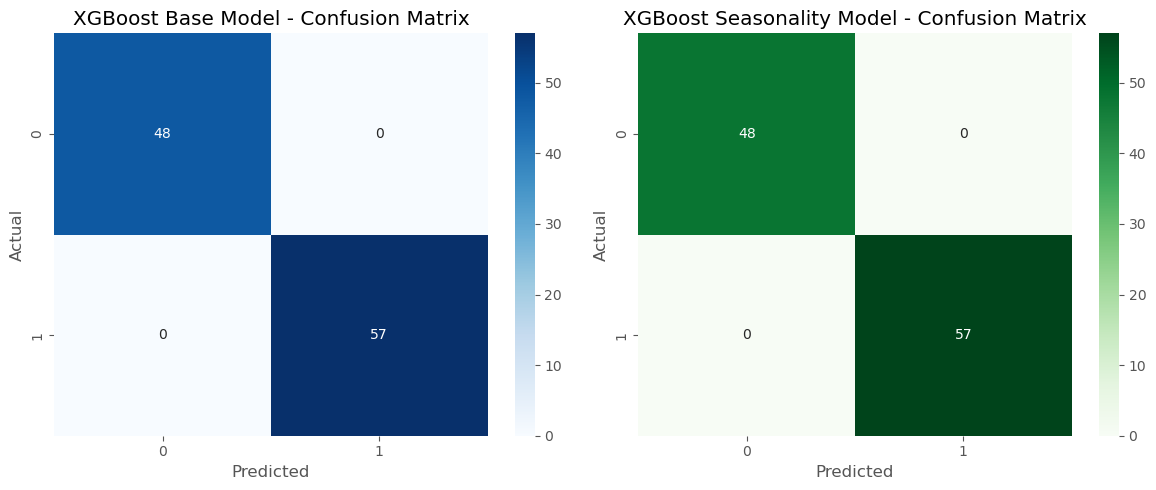

C:\Users\HP\AppData\Local\Temp\ipykernel_14200\3035259664.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='magma')


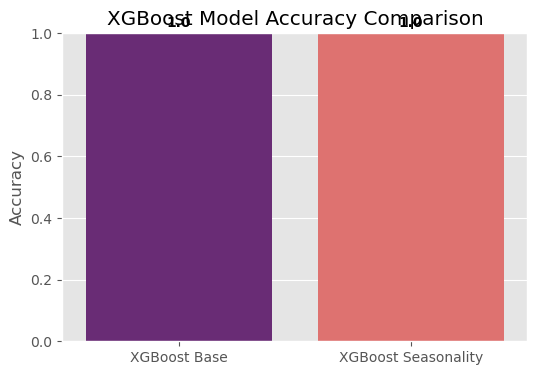

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


# -----------------------------
# Base XGBoost Model
# -----------------------------
xgb_base = XGBClassifier(
    n_estimators=200,        # Number of trees
    learning_rate=0.05,      # Step size shrinkage
    max_depth=5,             # Maximum depth of trees
    subsample=0.8,           # Row sampling
    colsample_bytree=0.8,    # Feature sampling
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_base.fit(X_train_base_clf, y_train_clf)

y_pred_xgb_base = xgb_base.predict(X_test_base_clf)
acc_xgb_base = round(accuracy_score(y_test_clf, y_pred_xgb_base), 3)
print("XGBoost Base Model Accuracy:", acc_xgb_base)


# -----------------------------
# Seasonality XGBoost Model
# -----------------------------
xgb_season = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_season.fit(X_train_season_clf, y_train_clf)

y_pred_xgb_season = xgb_season.predict(X_test_season_clf)
acc_xgb_season = round(accuracy_score(y_test_clf, y_pred_xgb_season), 3)
print("XGBoost Seasonality Model Accuracy:", acc_xgb_season)


# -----------------------------
# Confusion Matrix Visualization
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_clf, y_pred_xgb_base),
            annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('XGBoost Base Model - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test_clf, y_pred_xgb_season),
            annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('XGBoost Seasonality Model - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# -----------------------------
# Accuracy Comparison Bar Plot
# -----------------------------
models = ['XGBoost Base', 'XGBoost Seasonality']
accuracies = [acc_xgb_base, acc_xgb_season]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies, palette='magma')
plt.title("XGBoost Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, str(v), ha='center', fontweight='bold')
plt.show()





Neural Network Models (Base & Seasonality)
-

=== Neural Network (MLP) Classification ===
Base MLP Accuracy: 0.59
Seasonality MLP Accuracy: 0.571

=== Neural Network (MLP) Regression ===
Base MLP RMSE: 0.878
Base MLP R²: 0.999


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Seasonality MLP RMSE: 3.165
Seasonality MLP R²: 0.987


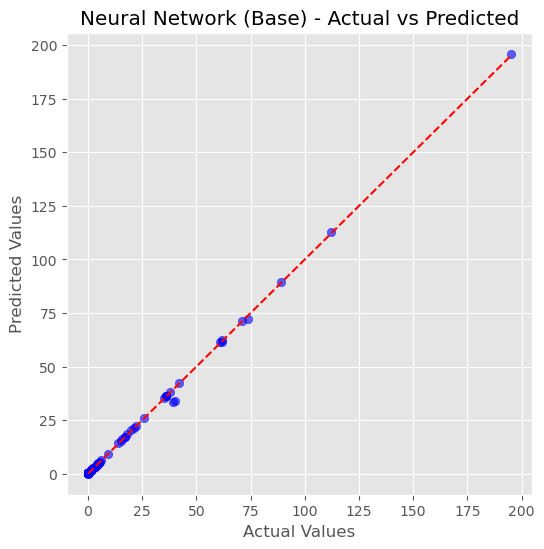

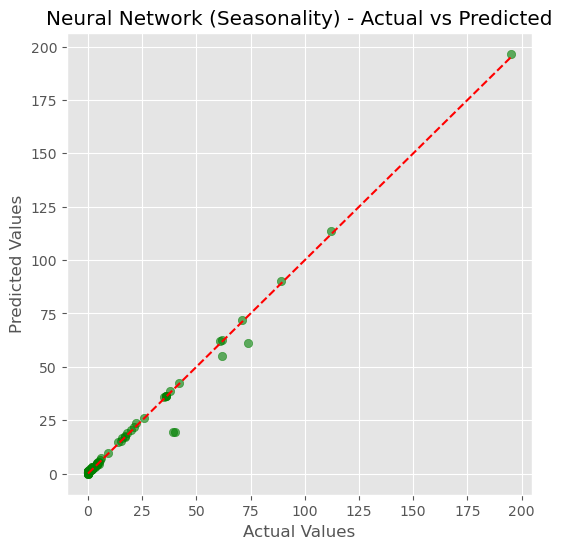

In [48]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Neural Network CLASSIFICATION
# -----------------------------
print("=== Neural Network (MLP) Classification ===")

# Base MLP Classifier
mlp_base_clf = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp_base_clf.fit(X_train_base_clf, y_train_clf)
y_pred_mlp_base_clf = mlp_base_clf.predict(X_test_base_clf)
acc_mlp_base = accuracy_score(y_test_clf, y_pred_mlp_base_clf)
print("Base MLP Accuracy:", round(acc_mlp_base, 3))

# Seasonality MLP Classifier
mlp_season_clf = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp_season_clf.fit(X_train_season_clf, y_train_clf)
y_pred_mlp_season_clf = mlp_season_clf.predict(X_test_season_clf)
acc_mlp_season = accuracy_score(y_test_clf, y_pred_mlp_season_clf)
print("Seasonality MLP Accuracy:", round(acc_mlp_season, 3))


# -----------------------------
# Neural Network REGRESSION
# -----------------------------
print("\n=== Neural Network (MLP) Regression ===")

# Base MLP Regressor
mlp_base_reg = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp_base_reg.fit(X_train_base_reg, y_train_reg)
y_pred_mlp_base_reg = mlp_base_reg.predict(X_test_base_reg)
rmse_mlp_base = np.sqrt(mean_squared_error(y_test_reg, y_pred_mlp_base_reg))
r2_mlp_base = r2_score(y_test_reg, y_pred_mlp_base_reg)
print("Base MLP RMSE:", round(rmse_mlp_base, 3))
print("Base MLP R²:", round(r2_mlp_base, 3))

# Seasonality MLP Regressor
mlp_season_reg = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp_season_reg.fit(X_train_season_reg, y_train_reg)
y_pred_mlp_season_reg = mlp_season_reg.predict(X_test_season_reg)
rmse_mlp_season = np.sqrt(mean_squared_error(y_test_reg, y_pred_mlp_season_reg))
r2_mlp_season = r2_score(y_test_reg, y_pred_mlp_season_reg)
print("Seasonality MLP RMSE:", round(rmse_mlp_season, 3))
print("Seasonality MLP R²:", round(r2_mlp_season, 3))


# -----------------------------
# Plot: Actual vs Predicted (Regression)
# -----------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_mlp_base_reg, alpha=0.6, color="blue")
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], "r--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Neural Network (Base) - Actual vs Predicted")
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_mlp_season_reg, alpha=0.6, color="green")
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], "r--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Neural Network (Seasonality) - Actual vs Predicted")
plt.show()
